Note book to assess precipitation efficiency in RCE simulations

### Main settings

In [37]:
import numpy as np
import xarray as xr
import subprocess
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns
import pickle
from tqdm.notebook import tqdm_notebook
from scipy import stats
import pandas as pd

In [38]:
# Main settings

itest_select = 0 # 0 for RCE
# itest_select = 1 # 1 for Channel

# Write pickle files?
do_readwrite = True
do_readwrite = False

# Read/write/plot 2d variables?
do_2d_plots = True # 3-panel plots
do_2d_plots = False # 3-panel plots

# Read extra 3D variables?
save_extra = True
save_extra = False

pclass_names=["Non-cloud", "Deep", "Congestus", "Shallow", "Stratiform", "Anvil", "MCS"]
npclass=len(pclass_names)

### Experiment file & time setup, paths

In [39]:
datdir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/jruppert/wing_rce/'

# OSCER
# pickle_dir = datdir+'pickle_out/'
# HOME
pickle_dir = '../../pickle_out/wing_rce/'

# RCE square domain sims:
#   control: 24 3D files per day, but we read/retain only 4/day
#   radhomo: 4 3D files per day
# 
# Channel domain sims:
#   julian day starts at 80.5 but this is the actual start of simulation
#   runs out to 148-80.5 = 67.5 days

# 300 # seconds per step (= 5 min)
# 300*24 # label numbers

if itest_select == 0:

    # 3D output is
    #   24/day for RCE
    #   4/day for RCE_RH

    # Processing matches these by keeping only 4/day for RCE

    exp_name = 'RCE'
    tests = [
        'RCE_768_305_snd_newoutput',
        'RCE_768_305_radhomo',
        ]
    test_names = [
        'RCE',
        'RCE_RH',
        ]

    # Date range of complete dataset (don't change these)
    day_bounds_dset = (1,100)
    time_offset=0 # nd offset

    # Date range for analysis
    day_bounds = (1,100)
    # day_bounds = (90,100) # Extra variables written out for this time slice
    # day_bounds = (10,30) # Extra variables written out for this time slice

else:

    exp_name = 'Channel'
    tests = [
        'ch_rrtm305ri0',
        'ch_rrtm305ri0_radhomo',
        ]
    test_names = [
        'channel',
        'channel_radhomo',
        ]

    # Date range of complete dataset (don't change these)
    day_bounds_dset = (1,65)
    time_offset=-80.5 # nd offset

    # Date range for analysis
    day_bounds = (1,65)

In [40]:
def get_3d_files_times(test_name, all_3d_files, day_bounds):

    def get_times_files(file_tmp, times, files):
        try:
            ds = xr.open_dataset(file_tmp)
            times.append(ds['time'].squeeze().values + time_offset)
            files.append(file_tmp)
            ds.close()
        except:
            pass
        return times, files

    # Here is where we grab only for 4/day files
    dt = 1/4
    ifile_set = np.arange(day_bounds[0], day_bounds[1] + dt, dt)
    file_num_tag = ifile_set*300*24 # label numbers
    nfiles = len(ifile_set)

    times_3d = []
    files_3d = []
    for iifile in range(nfiles):
        file_tmp = all_3d_files[test_name][0][:-13] + str(int(file_num_tag[iifile])).zfill(10) + '.nc'
        times_3d, files_3d = get_times_files(file_tmp, times_3d, files_3d)
    times_3d = np.array(times_3d)
    # nt = len(times_3d)
    # print(nt)
    return times_3d, files_3d

#### Read coordinates

In [41]:
# Read/write domain variables, time arrays to pickle
pickle_file_exper_settings = pickle_dir+'exper_coords_'+exp_name+'.pickle'

try:
# Try to read pickle first

    # Read from pickle
    with open(pickle_file_exper_settings, 'rb') as f:
        pickle_in = pickle.load(f)

    print('Successfully read in from pickle file')

    x = pickle_in['x']
    y = pickle_in['y']
    z = pickle_in['z']
    nx = pickle_in['nx']
    ny = pickle_in['ny']
    nz = pickle_in['nz']
    times_3d = pickle_in['times_3d']
    files_3d = pickle_in['files_3d']
    times_3d_rh = pickle_in['times_3d_rh']
    files_3d_rh = pickle_in['files_3d_rh']

except FileNotFoundError:
# If not found, write it

    print('Pickle file not found, writing file...')

    all_3d_files = {}
    for itest, isim in enumerate(tests):
        process = subprocess.Popen(['ls '+datdir+isim+'/NC_files/OUT_3D/*nc'],shell=True,
            stdout=subprocess.PIPE,universal_newlines=True)
        files = process.stdout.readlines()
        nfiles = len(files)
        # print(nfiles)
        for ifil in range(nfiles):
            files[ifil] = files[ifil].strip()
        all_3d_files[test_names[itest]] = files

    file_3d = xr.open_dataset(all_3d_files[test_names[0]][0])
    x = file_3d.coords['x'].values/1e3 # km
    y = file_3d.coords['y'].values/1e3 # km
    z = file_3d.coords['z'].values/1e3 # km
    nx = file_3d.coords['x'].size
    ny = file_3d.coords['y'].size
    nz = file_3d.coords['z'].size
    file_3d.close()

    # Write to pickle
    times_3d, files_3d = get_3d_files_times(test_names[0], all_3d_files, day_bounds_dset)
    times_3d_rh, files_3d_rh = get_3d_files_times(test_names[1], all_3d_files, day_bounds_dset)

    with open(pickle_file_exper_settings, 'wb') as f:
        pickle.dump({
            'x': x,
            'y': y,
            'z': z,
            'nx': nx,
            'ny': ny,
            'nz': nz,
            'times_3d': times_3d,
            'files_3d': files_3d,
            'times_3d_rh': times_3d_rh,
            'files_3d_rh': files_3d_rh
        }, f)

# Apply analysis day bounds to times and files
times_3d = times_3d[(times_3d >= day_bounds[0]) & (times_3d <= day_bounds[1])]
files_3d = [f for t, f in zip(times_3d, files_3d) if t >= day_bounds[0] and t <= day_bounds[1]]

Successfully read in from pickle file


### Read functions

#### 2D read functions

In [42]:
# Find matching time steps and read 2D files

# 2D output is hourly (24/day)
# Data is contained in 3 files, with 1000, 1000, 400 time steps

def get_sfc_variables(exp_name, day_bounds, tests, times_3d, times_3d_rh):

    if exp_name == 'RCE':
        read_files_2d = [
            datdir+tests[0]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_1.nc',
            datdir+tests[0]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_2.nc',
            datdir+tests[0]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_3.nc'
            ]
        read_files_2d_rh = [
            datdir+tests[1]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_1.nc',
            datdir+tests[1]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_2.nc',
            datdir+tests[1]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_3.nc'
            ]
        # if day_bounds[0] < 42:
        #     read_file_2d    = datdir+tests[0]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_1.nc'
        #     read_file_2d_rh = datdir+tests[1]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_1.nc'
        # elif day_bounds[0] < 84:
        #     read_file_2d    = datdir+tests[0]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_2.nc'
        #     read_file_2d_rh = datdir+tests[1]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_2.nc'
        # else:
        #     read_file_2d    = datdir+tests[0]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_3.nc'
        #     read_file_2d_rh = datdir+tests[1]+'/NC_files/OUT_2D/RCE_large_256x256x64_3km_12s_305K_64.2Dcom_3.nc'
    elif exp_name == 'Channel':
        raise ValueError('Need to update this for Channel sims')
        # if day_bounds[0] < 43:
        #     read_file_2d    = datdir+tests[0]+'/NC_files/OUT_2D/ch_rrtm305ri0_4096x64x64_3km_12s_rrtm305ri0_64.2Dcom_1.nc'
        #     read_file_2d_rh = datdir+tests[1]+'/NC_files/OUT_2D/ch_rrtm305ri0_radhomo_4096x64x64_3km_12s_rrtm305ri0_radhomo_64.2Dcom_1.nc'
        # else:
        #     read_file_2d    = datdir+tests[0]+'/NC_files/OUT_2D/ch_rrtm305ri0_4096x64x64_3km_12s_rrtm305ri0_64.2Dcom_2.nc'
        #     read_file_2d_rh = datdir+tests[1]+'/NC_files/OUT_2D/ch_rrtm305ri0_radhomo_4096x64x64_3km_12s_rrtm305ri0_radhomo_64.2Dcom_2.nc'

    print('Open files')
    ds_2d    = xr.open_mfdataset(read_files_2d)
    ds_2d_rh = xr.open_mfdataset(read_files_2d_rh)

    print('Match times')
    imatch = np.where((ds_2d['time'] > times_3d[0]) & (ds_2d['time'] < times_3d[-1]))[0]
    imatch = []
    for it in times_3d:
        imatch.append(np.where((ds_2d['time'] == it))[0][0])
    imatch = np.array(imatch)

    imatch_rh = np.where((ds_2d_rh['time'] > times_3d_rh[0]) & (ds_2d_rh['time'] < times_3d_rh[-1]))[0]
    imatch_rh = []
    for it in times_3d_rh:
        imatch_rh.append(np.where((ds_2d_rh['time'] == it))[0][0])
    imatch_rh = np.array(imatch_rh)

    def read_vars(ds, imatch):
        vars={}
        units={}
        lwns   = ds['LWNS'][imatch,:,:].values
        lwnsc  = ds['LWNSC'][imatch,:,:].values
        lwnt   = ds['LWNT'][imatch,:,:].values
        lwntc  = ds['LWNTC'][imatch,:,:].values
        lw_acre_t = lwnt - lwntc
        lw_acre_s = lwns - lwnsc
        lwacre = lw_acre_s - lw_acre_t
        vars['lwacre'] = lwacre
        units['lwacre'] = ds['LWNS'].attrs['units']
        vars['iwp'] = ds['IWP'][imatch,:,:].values
        units['iwp'] = ds['IWP'].attrs['units']
        vars['lwp'] = ds['CWP'][imatch,:,:].values
        units['lwp'] = ds['CWP'].attrs['units']
        vars['pw'] = ds['PW'][imatch,:,:].values
        units['pw'] = ds['PW'].attrs['units']
        vars['rain'] = ds['Prec'][imatch,:,:].values
        units['rain'] = ds['Prec'].attrs['units']
        vars['hNetLW'] = ds['hNetLW'][imatch,:,:].values
        units['hNetLW'] = ds['hNetLW'].attrs['units']
        vars['hNetSW'] = ds['hNetSW'][imatch,:,:].values
        units['hNetSW'] = ds['hNetSW'].attrs['units']
        vars['var_h'] = ds['var_h'][imatch,:,:].values
        units['var_h'] = ds['var_h'].attrs['units']
        return vars

    print('Read variables for RCE')
    vars2d, units = read_vars(ds_2d, imatch)
    print('Read variables for RCE_RH')
    vars2d_rh, units_rh = read_vars(ds_2d_rh, imatch_rh)

    ds_2d.close()
    ds_2d_rh.close()

    return vars2d, units, vars2d_rh, units_rh

#### 3D read functions

In [43]:
# Functions for reading 3D variables

def precip_class(q_int):

    shape = q_int.shape
    ndims=len(shape)
    shape_out = shape[1:ndims]

    # Integrated water variables
    LWP = q_int[0] + q_int[1]               # Liquid water path = cloud + rain
    IWP = q_int[2] + q_int[3] + q_int[4]    # Ice water path = ice + snow + graupel
    TWP = LWP + IWP                         # Total water path [mm]

    IWP = np.ma.masked_where((LWP == 0), IWP, copy=False)

    # Threshold p]arameters
    twp_thresh = 1e-1
    cr_thresh = 2
    # ice_thresh = 1e-8
    graup_thresh = 1e-4
    rain_thresh_conv = 1e-1
    rain_thresh_strat = 1e-2

    # Initialize output array
    if np.ma.is_masked(q_int):
        c_type = np.ma.zeros(shape_out, dtype=np.int8)
        domask=True
    else:
        c_type = np.zeros(shape_out, dtype=np.int8)
        domask=False

    cr = IWP/LWP

    # Deep convection
    c_type[( ((LWP != 0) & (TWP > twp_thresh)) &
            (cr <= cr_thresh) &
            (q_int[1] >= rain_thresh_conv) &
            (q_int[4] >= graup_thresh) ).nonzero() ] = 1
    # Congestus
    c_type[( ((LWP != 0) & (TWP > twp_thresh)) &
            (cr <= cr_thresh) &
            (q_int[1] >= rain_thresh_conv) &
            (q_int[4] < graup_thresh) ).nonzero() ] = 2
    # Shallow
    c_type[( ((LWP != 0) & (TWP > twp_thresh)) &
            (cr <= cr_thresh) &
            (q_int[1] < rain_thresh_conv) ).nonzero() ] = 3
    # Stratiform
    c_type[( ((LWP != 0) & (TWP > twp_thresh)) &
            (cr > cr_thresh) &
            (q_int[1] >= rain_thresh_strat) ).nonzero() ] = 4
    # Anvil
    c_type[( ((LWP != 0) & (TWP > twp_thresh)) &
            (cr > cr_thresh) &
            (q_int[1] < rain_thresh_strat) ).nonzero() ] = 5

    # Fill in mask of original array if it exists
    if domask:
        c_type.mask = q_int.mask[0,...]

    return c_type

def get_q_cloud(T, qn, qp):
    qcloud = np.maximum(0,np.minimum(1,(T-253.16)/20))*qn # %cloud water kg/kg
    qice   = (1-np.maximum(0,np.minimum(1,(T-253.16)/20)))*qn # %cloud ice kg/kg
    qrain  = np.maximum(0,np.minimum(1,(T-268.16)/15))*qp # %precipitating water kg/kg
    # qsnow  = (1-np.maximum(0,np.minimum(1,(T-268.16)/15)))*qp # %precipitating ice kg/kg
    qsnow = (1-np.maximum(0,np.minimum(1,(T-268.16)/15))*(1-np.maximum(0,np.minimum(1,(T-223.16)/(60)))))*qp # snow g/g
    qgraupel = (1-np.maximum(0,np.minimum(1,(T-268.16)/15))*np.maximum(0,np.minimum(1,(T-223.16)/(60))))*qp # graupel g/g

    return qcloud, qice, qrain, qsnow, qgraupel

def get_dse(tmpk):
    # Constants
    cp=1004. # J/K/kg
    g=9.81 # m/s2
    # Dry static energy (DSE)
    dse = cp*tmpk + g*z[:,np.newaxis,np.newaxis]*1e3 # J/kg
    return dse

def get_3d_vars(files, save_extra=False):

    nt = len(files)
    vmf = np.zeros((nt, ny, nx))
    wu_sav = np.zeros((nt, ny, nx))
    wd_sav = np.zeros((nt, ny, nx))
    pclass = np.zeros((nt, ny, nx))
    if save_extra:
        w_sav = np.zeros((nt, nz, ny, nx))
        dse = np.zeros((nt, nz, ny, nx))
        qrad_sav = np.zeros((nt, nz, ny, nx))

    for it, file in enumerate(tqdm_notebook(files)):

        ds = xr.open_dataset(file)

        # Precipitating and non-precipitating condensate
        qn = ds['QN'].squeeze().values*1e-3 # g/kg --> kg/kg
        qp = ds['QP'].squeeze().values*1e-3 # g/kg --> kg/kg
        tmpk = ds['TABS'].squeeze().values # K

        p0 = ds['p'].squeeze().values*1e2 # Pa
        pres = p0[:,np.newaxis,np.newaxis] + ds['PP'].squeeze().values # Pa

        w = ds['W'].squeeze().values # m/s

        if save_extra:
            w_sav[it] = w
            dse[it] = get_dse(tmpk) # J/kg
            try:
                qrad_sav[it] = ds['QRAD'].squeeze().values # K/d
            except:
                pass

        ds.close()

        g = 9.81 # m/s2
        dp = np.gradient(pres, axis=0)*-1 # Pa

        # Get vertically integrated cloud variables
        qcloud, qice, qrain, qsnow, qgraupel = get_q_cloud(tmpk, qn, qp)
        q_int = []
        for iq in [qcloud, qrain, qice, qsnow, qgraupel]:
            q_int.append(np.sum(iq*dp/g, axis=0))
        q_int = np.array(q_int)
        pclass[it] = precip_class(q_int)

        vars = {}

        wu = np.where((w > 0), w, 0)
        wd = np.where((w < 0), w, 0)
        p_top = 100e2 # Pa
        # k_vint_top = np.where(pres == vint_top)[0][0]
        vmf[it] = np.sum(w*dp/g, axis=0, where=(pres >= p_top)) # kg/m/s
        wu_sav[it] = np.sum(wu*dp/g, axis=0, where=(pres >= p_top)) # kg/m/s
        wd_sav[it] = np.sum(wd*dp/g, axis=0, where=(pres >= p_top)) # kg/m/s

    vars['vmf'] = vmf
    vars['vmfu'] = wu_sav
    vars['vmfd'] = wd_sav
    vars['pclass'] = pclass
    if save_extra:
        vars['w'] = w_sav
        vars['dse'] = dse
        vars['qrad'] = qrad_sav

    return vars

### Main read/write block

In [44]:
# Read in all variables

pickle_file = pickle_dir+exp_name+'_days_'+str(times_3d[0])+'_'+str(times_3d[-1])+'.pickle'
pickle_file_2d = pickle_dir+exp_name+'_days_'+str(times_3d[0])+'_'+str(times_3d[-1])+'_2d.pickle'

# WRITE DATA
if do_readwrite:

    # if do_2d_plots:
    pickle_out_2d = {}
    vars2d, units, vars2d_rh, units_rh = get_sfc_variables(exp_name, day_bounds, tests, times_3d, times_3d_rh)
    pickle_out_2d['vars2d'] = vars2d
    pickle_out_2d['vars2d_rh'] = vars2d_rh
    pickle_out_2d['units'] = units
    pickle_out_2d['units_rh'] = units_rh
    # Save variables to pickle
    with open(pickle_file_2d, 'wb') as f:
        pickle.dump(pickle_out_2d, f)

    pickle_out = {}
    vars3d = get_3d_vars(files_3d, save_extra=save_extra)
    vars3d_rh = get_3d_vars(files_3d_rh, save_extra=save_extra)
    pickle_out['vars3d'] = vars3d
    pickle_out['vars3d_rh'] = vars3d_rh
    pickle_out['times3d'] = times_3d
    pickle_out['times3d_rh'] = times_3d_rh
    pickle_out['files3d'] = files_3d
    pickle_out['files3d_rh'] = files_3d_rh
    # Save variables to pickle
    with open(pickle_file, 'wb') as f:
        pickle.dump(pickle_out, f)

# READ DATA
else:

    # Read in variables from pickle
    with open(pickle_file, 'rb') as f:
        pickle_in = pickle.load(f)
        vars3d = pickle_in['vars3d']
        vars3d_rh = pickle_in['vars3d_rh']

    # Read in variables from pickle
    # if do_2d_plots:
    with open(pickle_file_2d, 'rb') as f:
        pickle_in = pickle.load(f)
        vars2d = pickle_in['vars2d']
        vars2d_rh = pickle_in['vars2d_rh']

### Vertical motion analysis

In [45]:
# Plot mean W profiles

analyze_w = True
analyze_w = False

if analyze_w:

    # Plot profiles of mean w as a way to test classification

    def plot_w_profiles(ivars, z):
        fig, ax = plt.subplots(1, 1, figsize=(4, 6))
        # Change the colormap
        cmap = sns.color_palette("tab10", 6)
        # Plot zero-line
        ax.axvline(0, color='k', lw=1, ls='-')
        for ipclass in [0, 1, 2, 3, 4, 5]:
            ind = (ivars['pclass'] == ipclass).nonzero()
            # Number of points in each class
            nclass = len(ind[0])
            wprof = np.mean(ivars['w'][ind[0],:,ind[1],ind[2]], axis=0)
            ax.plot(wprof, z, label=str(ipclass)+' n='+str(nclass), color=cmap[ipclass], linewidth=1.5)

        # Add "MCS" profile
        ind = ((ivars['pclass'] == 1) | (ivars['pclass'] == 4)).nonzero()
        # Number of points in each class
        nclass = len(ind[0])
        wprof = np.mean(ivars['w'][ind[0],:,ind[1],ind[2]], axis=0)
        ax.plot(wprof, z, label=str(ipclass)+' n='+str(nclass), color='black', linewidth=1.5, ls='--')

        ax.set_xlabel('W [m/s]')
        ax.set_ylabel('z [km]')
        ax.set_title('W profiles')
        ax.legend(fontsize=8)
        ax.set_ylim(0, 17)
        plt.tight_layout()
        plt.show()
        plt.close()
        return None

    # Plot W profiles
    plot_w_profiles(vars3d, z)
    # plot_w_profiles(vars3d_rh, z)


    # Plot profiles of radiative forcing

    def plot_qrad_profiles(ivars, ivars_rh, z):
        fig, ax = plt.subplots(1, 3, figsize=(7, 4))

        # P-class selection
        # pclass_select = [0,1,2,3,4,5]
        pclass_select = [1,4,5]

        # Change the colormap
        # cmap = sns.color_palette("tab10", 6)
        cmap = sns.color_palette('deep', len(pclass_select))

        for iax in range(len(ax)):
            ax[iax].set_ylim(0, 17)
            # Plot zero-line
            ax[iax].axvline(0, color='k', lw=1, ls='-')

        lw = 1.5

        qrad_mean_prof = np.mean(ivars['qrad'], axis=(0,2,3))
        for i, ipclass in enumerate(pclass_select):

            ind = (ivars['pclass'] == ipclass).nonzero()
            # Number of points in each class
            nclass = len(ind[0])

            qrad_prof = np.mean(ivars['qrad'][ind[0],:,ind[1],ind[2]], axis=0)
            # ax[0].plot(qrad_prof, z, color=cmap[i], linewidth=lw, label=str(ipclass)+' n='+str(nclass))

            crf_prof = qrad_prof - qrad_mean_prof
            ax[0].plot(crf_prof, z, color=cmap[i], linewidth=lw, label=str(ipclass))#+' n='+str(nclass))

            w_prof = np.mean(ivars['w'][ind[0],:,ind[1],ind[2]], axis=0)
            ax[1].plot(w_prof, z, color=cmap[i], linewidth=lw)

            ind_rh = (ivars_rh['pclass'] == ipclass).nonzero()
            w_prof_rh = np.mean(ivars_rh['w'][ind_rh[0],:,ind_rh[1],ind_rh[2]], axis=0)
            ax[1].plot(w_prof_rh, z, color=cmap[i], linewidth=lw, ls='--')

            w_prime = w_prof - w_prof_rh
            dse_mean = np.mean(ivars['dse'][ind[0],:,ind[1],ind[2]], axis=0)
            dsdz = np.gradient(dse_mean, z*1e3)
            crf_wtg = (crf_prof*1004/(24*3600)) / dsdz
            # ax[3].plot(w_prime, z, color=cmap[i], linewidth=lw)
            ax[2].plot(crf_wtg, z, color=cmap[i], linewidth=lw, ls='--')

        ax[2].set_xlim(-0.05, 0.05)

        # Add "MCS" profile
        # ind = ((ivars['pclass'] == 1) | (ivars['pclass'] == 4)).nonzero()
        # # Number of points in each class
        # nclass = len(ind[0])
        # wprof = np.mean(ivars['w'][ind[0],:,ind[1],ind[2]], axis=0)
        # ax.plot(wprof, z, label=str(ipclass)+' n='+str(nclass), color='black', linewidth=1.5, ls='--')

        # ax[0].set_xlabel('$R$ [K/d]')
        ax[0].set_ylabel('z [km]')
        # ax.set_title('W profiles')
        ax[0].legend(fontsize=8)
        sns.despine(offset=10,ax=ax[0])#, left=False, bottom=True)

        for iax in range(1,len(ax)):
            sns.despine(offset=10,ax=ax[iax], left=True, bottom=False, right=True)
            # Remove ticks and labels
            ax[iax].set_yticklabels([])
            ax[iax].tick_params(axis='y', left=False)
        ax[0].set_xlabel("$R'$ [K/d]")
        ax[1].set_xlabel("$w$ [m/s]")
        ax[2].set_xlabel("$w'$ [m/s]")

        plt.tight_layout()
        plt.show()
        plt.close()
        return None

    plot_qrad_profiles(vars3d, vars3d_rh, z)
    # plot_qrad_profiles(vars3d_rh, vars3d, z)

### Plot OLR

In [110]:
vars2d['pw'].shape
vars2d.keys()

dict_keys(['lwacre', 'iwp', 'lwp', 'pw', 'rain'])

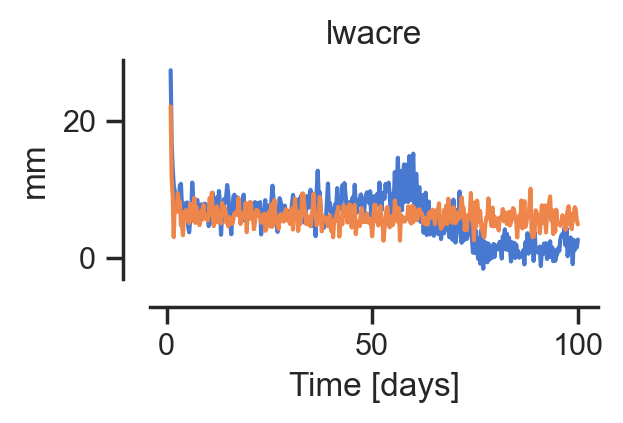

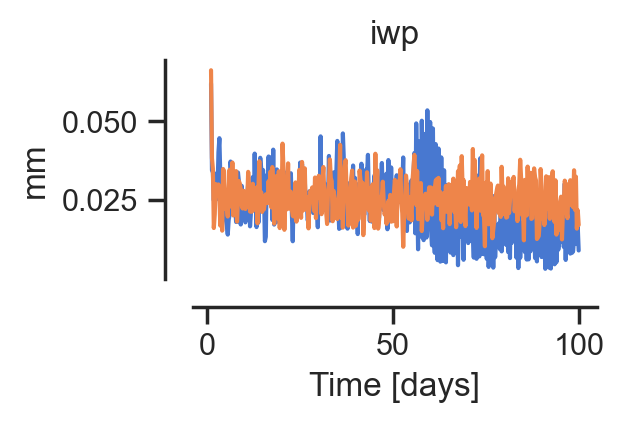

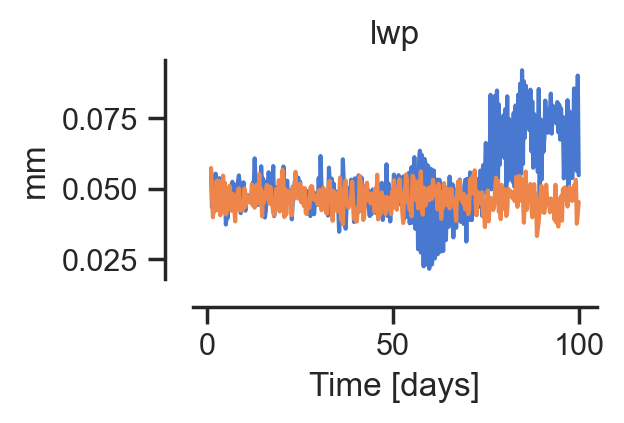

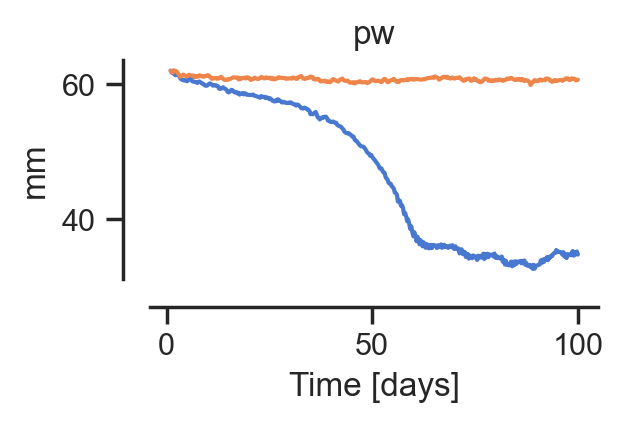

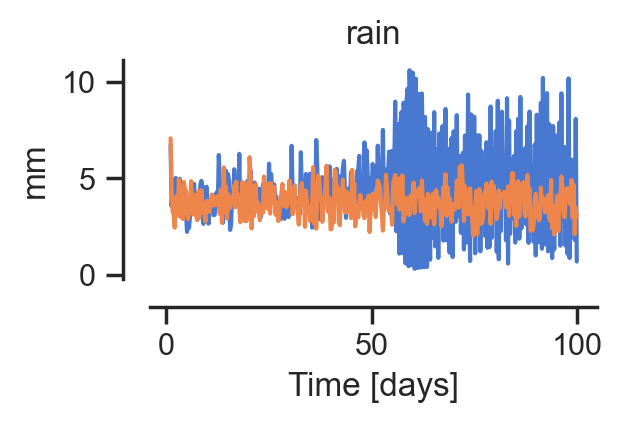

In [116]:
fig, axs = plt.subplots(1,1, figsize=(3,2), layout='constrained', squeeze=True, dpi=200)
sns.set_palette('muted')

units = ['W/m$^2$', 'mm', 'mm', 'mm', 'mm/d']

for iv, ivar in enumerate(vars2d.keys()):

    plt.plot(times_3d, np.mean(vars2d[ivar], axis=(1,2)))
    # Overlay the mean PW from vars2d_rh
    plt.plot(times_3d_rh, np.mean(vars2d_rh[ivar], axis=(1,2)))#, color='red', linestyle='--')
    sns.despine(offset=10, right=True, top=True)
    # Add title
    plt.title(ivar)
    plt.xlabel('Time [days]')
    plt.ylabel(units[iv])

plt.show()
plt.close()

### Plot precip. effic.

#### PE function

In [63]:
def get_plot_vars(ivars):

    nt = ivars['vmf'].shape[0]

    # iwhere = np.where((ivars['pclass'] == 1) | (ivars['pclass'] == 4) | (ivars['pclass'] == 5))
    # var = (1 - (-ivars['vmfd']/ivars['vmfu']))[iwhere]

    vmfu = np.zeros(nt)
    vmfd = np.zeros(nt)
    for it in range(nt):
        # ind = (ivars['pclass'][it] == 1).nonzero()
        # ind = (ivars['pclass'][it] == 4).nonzero()
        # ind = ((ivars['pclass'][it] == 1) | (ivars['pclass'][it] == 4)).nonzero()
        ind = ((ivars['pclass'][it] == 1) | (ivars['pclass'][it] == 4) | (ivars['pclass'][it] == 5)).nonzero()
        # ind = ((ivars['pclass'][it] == 4) | (ivars['pclass'][it] == 5)).nonzero()
        # ind = ((ivars['pclass'][it] == 1)).nonzero()
        # ind = ((ivars['pclass'][it] == 4)).nonzero()
        # ind = ((ivars['pclass'][it] == 1) | (ivars['pclass'][it] == 2) | (ivars['pclass'][it] == 3)).nonzero()
        vmfu[it] = np.mean(ivars['vmfu'][it][ind])
        vmfd[it] = np.mean(ivars['vmfd'][it][ind])
    var = (1 - (-vmfd/vmfu))
    title = r'$\epsilon = 1 - M_d / M_u$'
    units = '-'

    return var.flatten(), units, title

#### Compare pre/post aggregation

10.0 30.0
10.0 30.0
80.0 100.0
80.0 100.0


/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_2835/1509310371.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


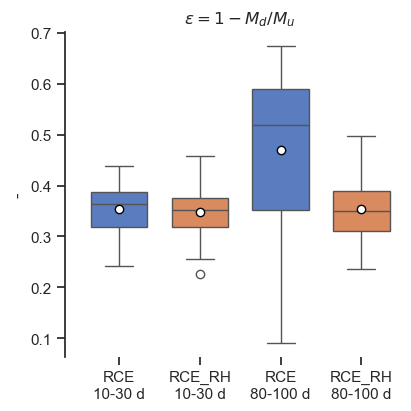

In [12]:
def histogram_plot(vars3d, vars3d_rh):
    # sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})
    sns.set_theme(style="ticks", rc={'xtick.bottom': True, 'ytick.left': True})#, "axes.spines.right": False, "axes.spines.top": False})
    # sns.set_theme(style="dark")

    fig_x = 4
    fig_y = 4
    fig, ax = plt.subplots(1,1, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
    # ax.set_ylabel('Density')
    # ax.set_xlabel('kg/m$^2$')

    # Read full variable
    ivar, units, title = get_plot_vars(vars3d)
    ivar_rh, units, title = get_plot_vars(vars3d_rh)
    ivar_all_sav = [ivar, ivar_rh]

    # Create subset for two different time intervals
    ivar_sav = []
    labels = []
    d_sel = [(9*4, 29*4),
             (-(20*4+1), -1)]
    for i_d_sel in d_sel:
        for i, (ivar, legend) in enumerate(zip(ivar_all_sav, test_names[0:2])):
            print(times_3d[i_d_sel[0]], times_3d[i_d_sel[1]])
            time_str = str(int(times_3d[i_d_sel[0]]))+'-'+str(int(times_3d[i_d_sel[1]]))+' d'
            ivar_sav.append(ivar[i_d_sel[0]:i_d_sel[1]])
            labels.append(legend + '\n'+time_str)

    # kde = sns.kdeplot(ivar, ax=ax, label=legend, fill=True, common_norm=True, color=default_colors[i])
    sns.set_palette('muted')
    colors = sns.color_palette()[:2]*2
    sns.boxplot([ivar_sav[ic] for ic in range(4)],
                width=0.7, showmeans=True,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"},
                palette=colors,)
    ax.set_xticklabels(labels)
    sns.despine(offset=10,ax=ax, left=False, bottom=True)
    plt.ylabel(units)
    plt.title(title)
    plt.show()
    plt.close()
    return None

histogram_plot(vars3d, vars3d_rh)

#### Time series

In [13]:
# Function to compute running mean
def running_mean_conf(time_series):
    nd_smooth = 6 # days
    ntpday = 4 # timesteps per day
    window_size = nd_smooth*ntpday  # Adjust as needed
    tser_smooth = np.convolve(time_series, np.ones(window_size) / window_size, mode='valid')
    # Compute standard error of the mean
    standard_error = stats.sem(time_series)  # Standard error of the original data
    confidence_interval = 1.96 * standard_error  # 95% confidence interval
    # res = stats.bootstrap((time_series,), np.mean, confidence_level=0.95)
    # confidence_interval = (res.confidence_interval.low, res.confidence_interval.high)
    return tser_smooth, confidence_interval, window_size

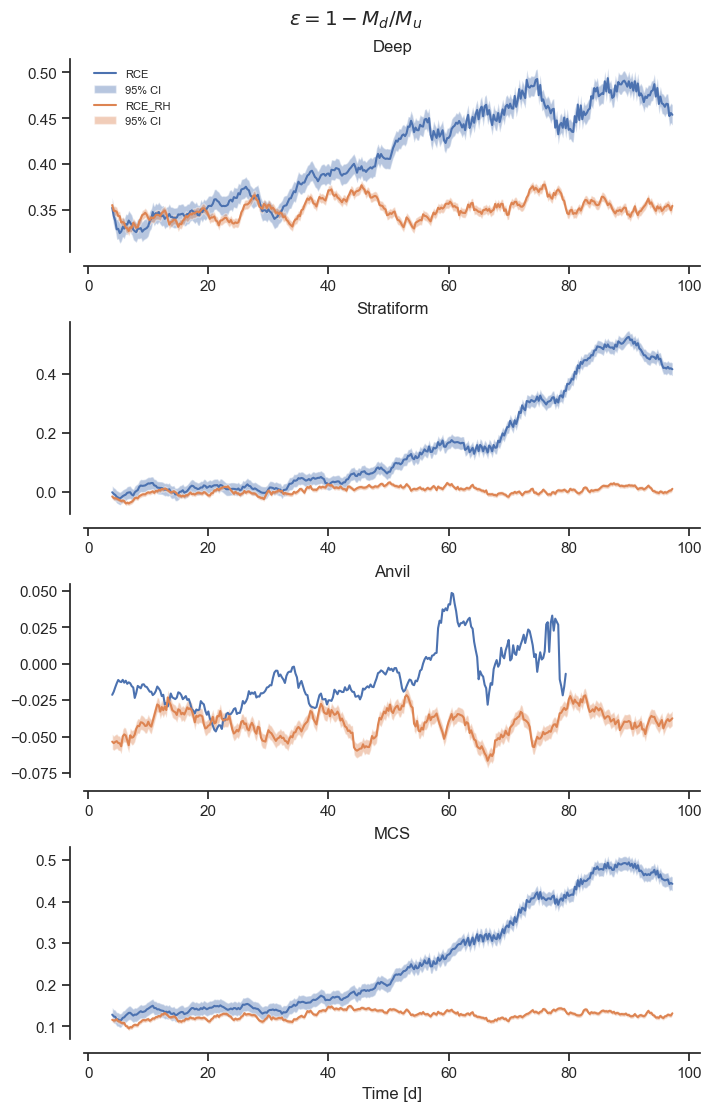

In [36]:
# Plot line plot with PE for both tests
def line_plot(vars3d, vars3d_rh):

    def get_plot_var_pclass(ivars, ipclass):
        nt = ivars['vmf'].shape[0]
        vmfu = np.zeros(nt)
        vmfd = np.zeros(nt)
        for it in range(nt):
            if ipclass < 6:
                ind = (ivars['pclass'][it] == ipclass).nonzero()
            elif ipclass == 6:
                ind = ((ivars['pclass'][it] == 1) | (ivars['pclass'][it] == 4) | (ivars['pclass'][it] == 5)).nonzero()
            vmfu[it] = np.mean(ivars['vmfu'][it][ind])
            vmfd[it] = np.mean(ivars['vmfd'][it][ind])
        var = (1 - (-vmfd/vmfu))
        return var

    pclass_plot = [1,4,5,6]
    # pclass_plot = [1,2,3,4,5,6]
    nclass_plot = len(pclass_plot)

    # sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})
    sns.set_theme(style="ticks", rc={'xtick.bottom': True, 'ytick.left': True})#, "axes.spines.right": False, "axes.spines.top": False})
    # sns.set_theme(style="dark")
    fig_x = 7
    fig_y = 11
    fig, axs = plt.subplots(nclass_plot, 1,figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
    sns.set_palette('muted')
    title = r'$\epsilon = 1 - M_d / M_u$'
    units = '-'
    plt.suptitle(title)

    nt = len(times_3d)
    for ipclass in range(nclass_plot):

        axs[ipclass].set_title(pclass_names[pclass_plot[ipclass]])
        for i, (ivars, legend) in enumerate(zip([vars3d, vars3d_rh], test_names)):
            ivar = get_plot_var_pclass(ivars, pclass_plot[ipclass])
            ivar_smooth, confidence_interval, nwindow = running_mean_conf(ivar)
            # ax.plot(times_3d, ivar, label=legend, linewidth=1.5)
            x_smoothed = times_3d[nwindow//2:-nwindow//2+1]
            axs[ipclass].plot(x_smoothed, ivar_smooth, label=legend, linewidth=1.5)
            axs[ipclass].fill_between(x_smoothed,
                # ivar_smooth - confidence_interval[0],
                # ivar_smooth + confidence_interval[1],
                ivar_smooth - confidence_interval,
                ivar_smooth + confidence_interval,
                alpha=0.4,label="95% CI",)
        sns.despine(offset=10,ax=axs[ipclass])#, left=True, bottom=True)
        # ax.spines['left'].set_visible(False)

    axs[-1].set_xlabel('Time [d]')

    axs[0].legend(loc='upper left', fontsize=8, frameon=False)
    plt.show()
    plt.close()
    return None

line_plot(vars3d, vars3d_rh)

#### Combined plot

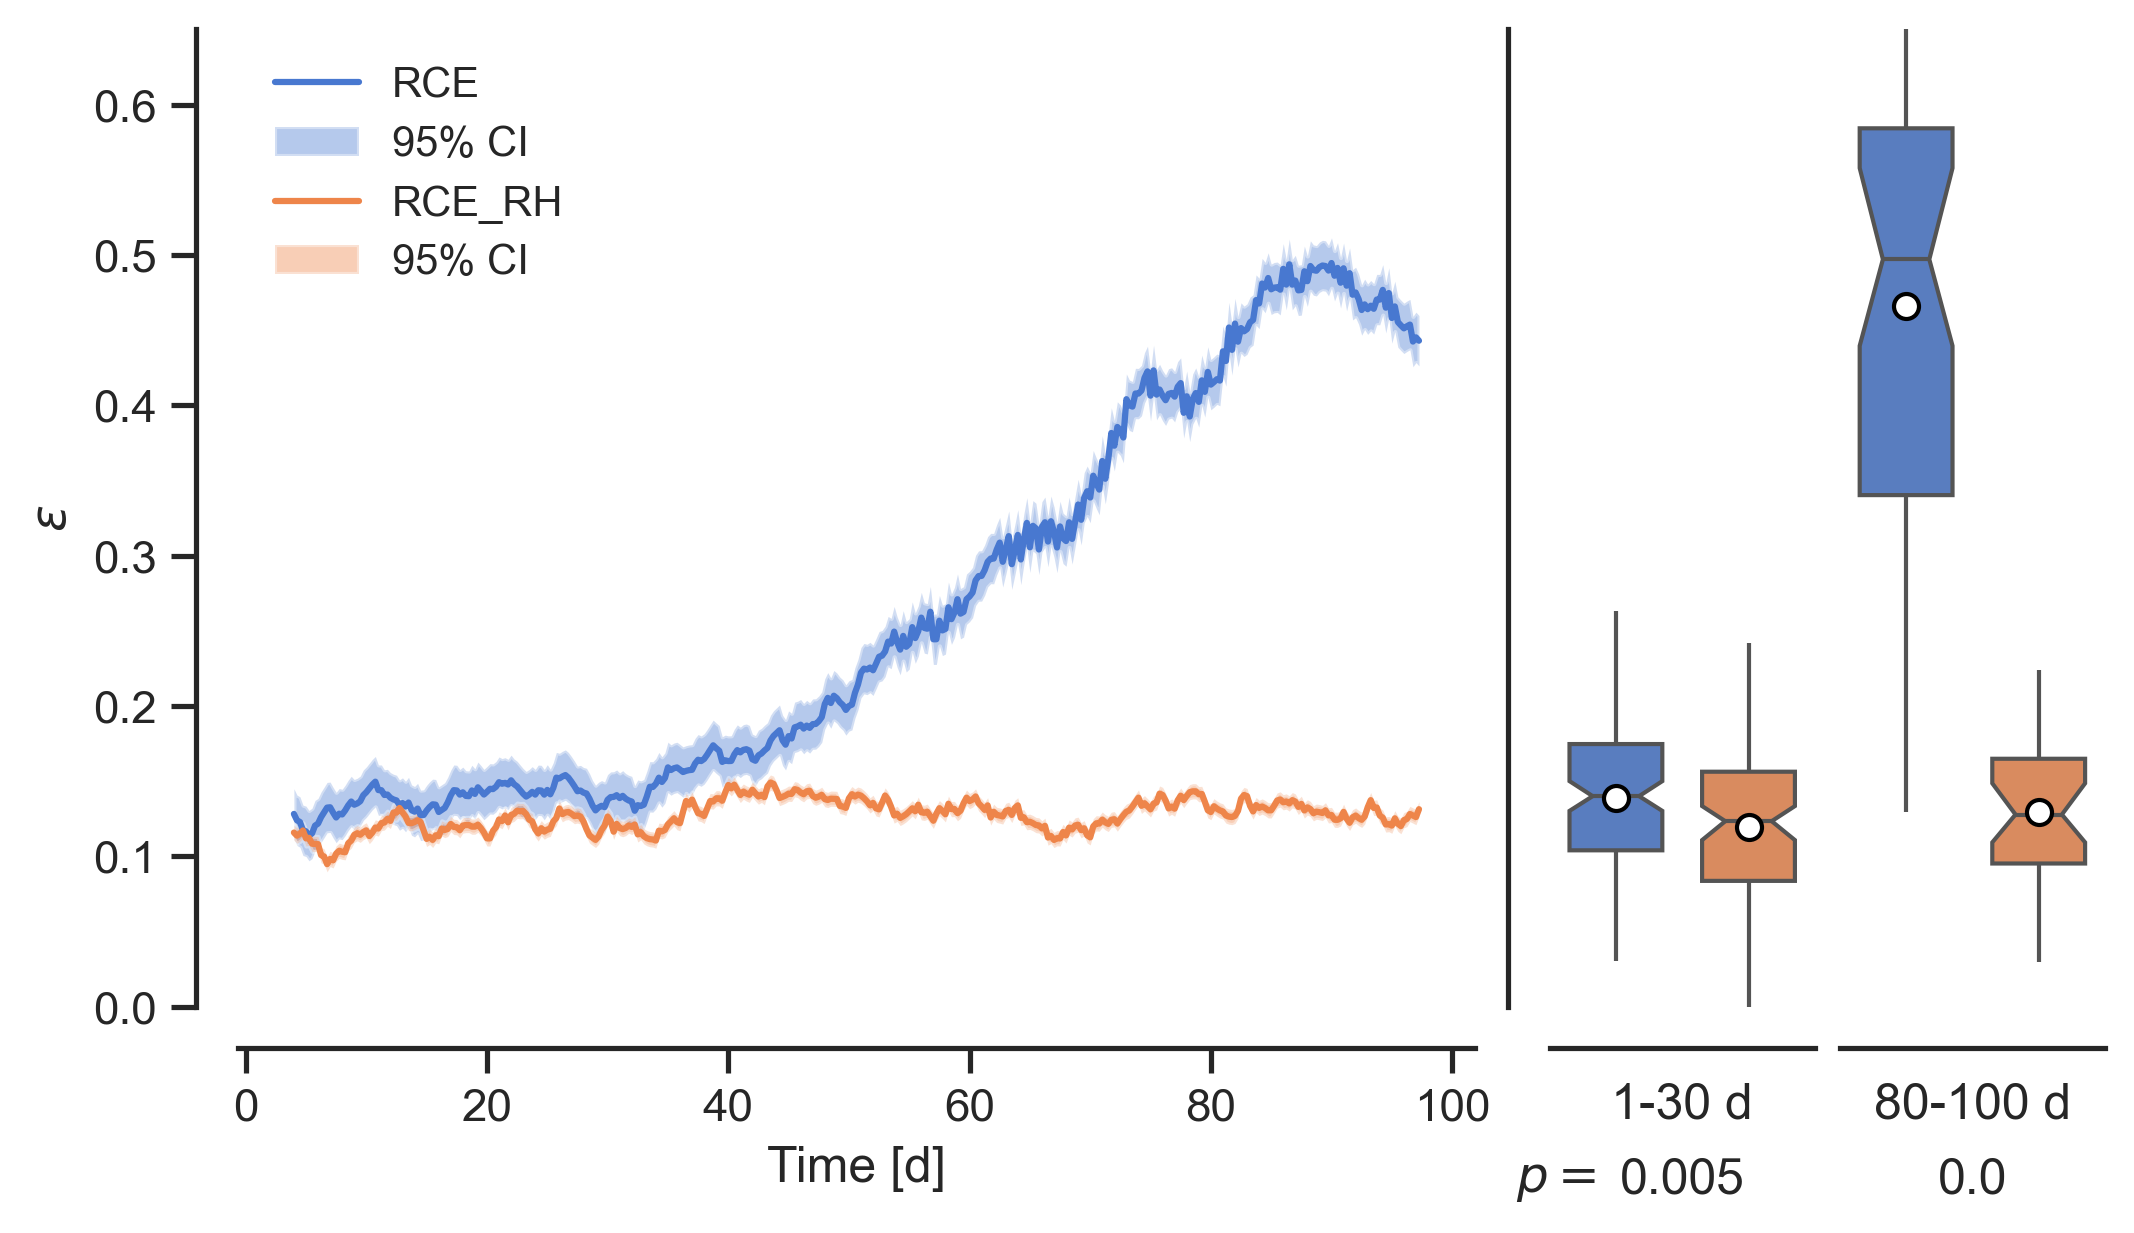

In [ ]:
def combined_plot(vars3d, vars3d_rh):

    from scipy.stats import ttest_ind #, mannwhitneyu

    # Read full variable
    ivar, units, title = get_plot_vars(vars3d)
    ivar_rh, units, title = get_plot_vars(vars3d_rh)
    ivar_all_sav = [ivar, ivar_rh]

    fig_x = 7
    fig_y = 4
    fig, axs = plt.subplots(1,3, width_ratios=[0.7,0.15,0.15], figsize=(fig_x,fig_y), layout='constrained', squeeze=True, dpi=300)
    sns.set_palette('muted')
    title = r'$\epsilon$'# = 1 - M_d / M_u$'
    # plt.suptitle(title)
    axs[0].set_ylabel(title)

    #### Time series ########################

    # axs[1].set_ylabel(title)
    axs[0].set_xlabel('Time [d]')
    sns.despine(offset=10,ax=axs[0], left=False, right=True, bottom=False)
    
    for iax in range(3):
        axs[iax].set_ylim(0,.65)
    y_min, y_max = axs[0].get_ylim()

    # Plot line plot with PE for both tests
    for (ivar, legend) in zip(ivar_all_sav, test_names[0:2]):
        ivar_smooth, confidence_interval, nwindow = running_mean_conf(ivar)
        x_smoothed = times_3d[nwindow//2:-nwindow//2+1]
        axs[0].plot(x_smoothed, ivar_smooth, label=legend, linewidth=1.5, zorder=1)
        axs[0].fill_between(x_smoothed, ivar_smooth - confidence_interval,
                            ivar_smooth + confidence_interval,
                            alpha=0.4, label="95% CI", zorder=0)

    # Add legend for axis
    axs[0].legend(fontsize=10, frameon=False)

    #### Boxplots ########################

    ivar_sav = []
    # conf_interval_sav = []
    labels = []
    # d_sel = [(9*4, 29*4),
    d_sel = [(0, 29*4),
             (-(20*4+1), -1)]
    for isel, i_d_sel in enumerate(d_sel):
        for i, (ivar, legend) in enumerate(zip(ivar_all_sav, test_names[0:2])):
        # for i, (ivar, legend) in enumerate(zip(ivar_all_smooth, test_names[0:2])):
        # for i, (ivar, legend) in enumerate(zip(ivar_all_diff, test_names[0:2])):
            time_str = str(int(times_3d[i_d_sel[0]]))+'-'+str(int(times_3d[i_d_sel[1]]))+' d'
            ivar_sav.append(ivar[i_d_sel[0]:i_d_sel[1]])
            # ivar_smooth, confidence_interval, nwindow = running_mean_conf(ivar[i_d_sel[0]:i_d_sel[1]])
            # conf_interval_sav.append(confidence_interval)
            # labels.append(legend + '\n'+time_str)
            labels.append(legend)

        # Add labels to boxplot x-axis
        axs[isel+1].text(0.5, y_min-0.05, time_str, ha='center', va='top')#, fontsize=10)

        # Statistical significant (two-sided T-test)
        t_stat, p_value = ttest_ind(ivar_all_sav[0][i_d_sel[0]:i_d_sel[1]],
                                    ivar_all_sav[1][i_d_sel[0]:i_d_sel[1]],
                                    equal_var=True)
        axs[isel+1].text(0.5, y_min-0.10, str(np.round(p_value,3)), ha='center', va='top')#, fontsize=10)
    axs[1].text(-0.15, y_min-0.10, '$p=$', ha='right', va='top')#, fontsize=10)

    colors = sns.color_palette()[:2]
    sns.boxplot([ivar_sav[ic] for ic in range(2)],
                width=0.7, showmeans=True,
                meanprops={"marker":"o", "markerfacecolor":"white",
                           "markeredgecolor":"black", "markersize":"6"},
                palette=colors,
                ax=axs[1], notch=True, showcaps=False, bootstrap=10000,
                showfliers=True,)
                # boxprops=dict(alpha=0.85))

    sns.boxplot([ivar_sav[ic] for ic in range(2,4)],
                width=0.7, showmeans=True,
                meanprops={"marker":"o", "markerfacecolor":"white",
                           "markeredgecolor":"black", "markersize":"6"},
                palette=colors,
                ax=axs[2], notch=True, showcaps=False, bootstrap=10000,
                showfliers=True,)
                # boxprops=dict(alpha=0.85))

    for iax in range(1,3):
        # Get rid of y-axis ticks
        axs[iax].set_yticks([])
        axs[iax].set_xticks([])
        sns.despine(offset=10,ax=axs[iax], left=True, bottom=False)
    sns.despine(offset=10,ax=axs[1], left=False, bottom=False)

    # Retrieve the maximum y-values of the whiskers and plot labels above them
    # for ic in range(4):  # Loop through each boxplot's data
    #     data = ivar_sav[ic]
    #     q1 = np.percentile(data, 25)  # First quartile (Q1)
    #     q3 = np.percentile(data, 75)  # Third quartile (Q3)
    #     iqr = q3 - q1  # Interquartile range
    #     maxval = q3 + 1.5 * iqr
    #     minval = q1 - 1.5 * iqr
    #     # Find max data values within these limits
    #     data_max = np.max(data[data <= maxval])
    #     data_min = np.min(data[data >= minval])
    #     buff = 0.03
    #     if ic % 2 == 0: # Check if ic is even
    #         axs[1].text(ic, data_min - buff, labels[ic], ha='center', va='top', fontsize=10)
    #     else:
    #         axs[1].text(ic, data_max + buff, labels[ic], ha='center', va='bottom', fontsize=10)
    #     axs[1].text(ic, y_min-0.05, labels[ic], ha='center', va='bottom')#, fontsize=10)

    plt.show()
    # Save figure
    fig.savefig('rce_combined_plot.png', bbox_inches='tight')
    plt.close()
    return None

combined_plot(vars3d, vars3d_rh)

#### Combined plot v2

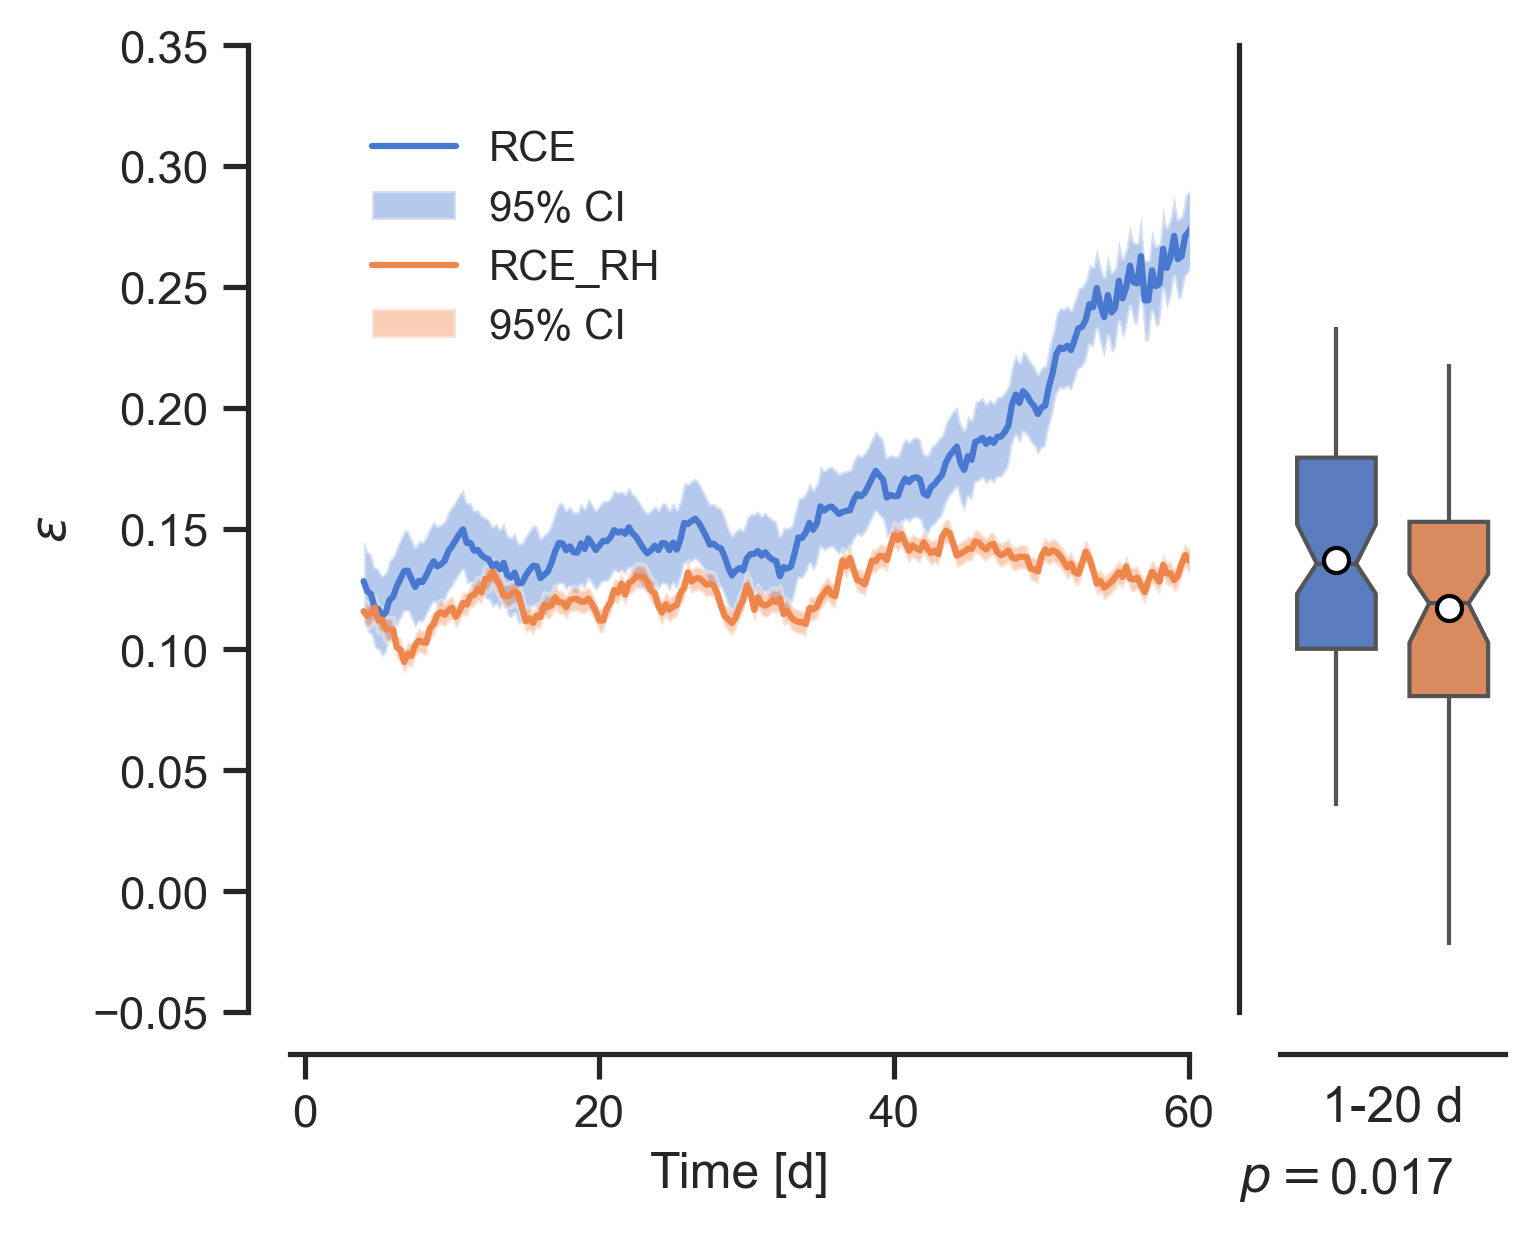

In [109]:
def combined_plot(vars3d, vars3d_rh):

    from scipy.stats import ttest_ind #, mannwhitneyu

    # Read full variable
    ivar, units, title = get_plot_vars(vars3d)
    ivar_rh, units, title = get_plot_vars(vars3d_rh)
    ivar_all_sav = [ivar, ivar_rh]

    fig_x = 5
    fig_y = 4
    fig, axs = plt.subplots(1,2, width_ratios=[0.8,0.2], figsize=(fig_x,fig_y), layout='constrained', squeeze=True, dpi=300)
    sns.set_palette('muted')
    title = r'$\epsilon$'# = 1 - M_d / M_u$'
    # plt.suptitle(title)
    axs[0].set_ylabel(title)

    #### Time series ########################

    # axs[1].set_ylabel(title)
    axs[0].set_xlabel('Time [d]')
    axs[0].set_xlim(-1, 60)
    sns.despine(offset=10,ax=axs[0], left=False, right=True, bottom=False)
    
    for iax in range(2):
        axs[iax].set_ylim(-0.05,.35)
    y_min, y_max = axs[0].get_ylim()

    # Plot line plot with PE for both tests
    for (ivar, legend) in zip(ivar_all_sav, test_names[0:2]):
        ivar_smooth, confidence_interval, nwindow = running_mean_conf(ivar)
        x_smoothed = times_3d[nwindow//2:-nwindow//2+1]
        axs[0].plot(x_smoothed, ivar_smooth, label=legend, linewidth=1.5, zorder=1)
        axs[0].fill_between(x_smoothed, ivar_smooth - confidence_interval,
                            ivar_smooth + confidence_interval,
                            alpha=0.4, label="95% CI", zorder=0)

    # Add legend for axis
    axs[0].legend(fontsize=10, frameon=False, loc='upper left', bbox_to_anchor=(0.05, 0.95))

    #### Boxplots ########################

    ivar_sav = []
    # conf_interval_sav = []
    labels = []
    d_sel = (0, 19*4)
    # d_sel = [(0, 29*4),
    #          (-(20*4+1), -1)]
    for i, (ivar, legend) in enumerate(zip(ivar_all_sav, test_names[0:2])):
        time_str = str(int(times_3d[d_sel[0]]))+'-'+str(int(times_3d[d_sel[1]]))+' d'
        ivar_sav.append(ivar[d_sel[0]:d_sel[1]])
        labels.append(legend)

    # Add labels to boxplot x-axis
    axs[1].text(0.5, y_min-0.03, time_str, ha='center', va='top')#, fontsize=10)

    # Statistical significant (two-sided T-test)
    t_stat, p_value = ttest_ind(ivar_all_sav[0][d_sel[0]:d_sel[1]],
                                ivar_all_sav[1][d_sel[0]:d_sel[1]],
                                equal_var=True)
    axs[1].text(0.5, y_min-0.06, str(np.round(p_value,3)), ha='center', va='top')#, fontsize=10)

    axs[1].text(-0.15, y_min-0.06, '$p=$', ha='right', va='top')#, fontsize=10)

    colors = sns.color_palette()[:2]
    sns.boxplot([ivar_sav[ic] for ic in range(2)],
                width=0.7, showmeans=True,
                meanprops={"marker":"o", "markerfacecolor":"white",
                           "markeredgecolor":"black", "markersize":"6"},
                palette=colors,
                ax=axs[1], notch=True, showcaps=False, bootstrap=10000,
                showfliers=True,)
                # boxprops=dict(alpha=0.85))

    # sns.boxplot([ivar_sav[ic] for ic in range(2,4)],
    #             width=0.7, showmeans=True,
    #             meanprops={"marker":"o", "markerfacecolor":"white",
    #                        "markeredgecolor":"black", "markersize":"6"},
    #             palette=colors,
    #             ax=axs[2], notch=True, showcaps=False, bootstrap=10000,
    #             showfliers=True,)
    #             # boxprops=dict(alpha=0.85))

    # for iax in range(1,2):
    # Get rid of y-axis ticks
    axs[1].set_yticks([])
    axs[1].set_xticks([])
    sns.despine(offset=10,ax=axs[iax], left=True, bottom=False)
    sns.despine(offset=10,ax=axs[1], left=False, bottom=False)

    # Retrieve the maximum y-values of the whiskers and plot labels above them
    # for ic in range(4):  # Loop through each boxplot's data
    #     data = ivar_sav[ic]
    #     q1 = np.percentile(data, 25)  # First quartile (Q1)
    #     q3 = np.percentile(data, 75)  # Third quartile (Q3)
    #     iqr = q3 - q1  # Interquartile range
    #     maxval = q3 + 1.5 * iqr
    #     minval = q1 - 1.5 * iqr
    #     # Find max data values within these limits
    #     data_max = np.max(data[data <= maxval])
    #     data_min = np.min(data[data >= minval])
    #     buff = 0.03
    #     if ic % 2 == 0: # Check if ic is even
    #         axs[1].text(ic, data_min - buff, labels[ic], ha='center', va='top', fontsize=10)
    #     else:
    #         axs[1].text(ic, data_max + buff, labels[ic], ha='center', va='bottom', fontsize=10)
    #     axs[1].text(ic, y_min-0.05, labels[ic], ha='center', va='bottom')#, fontsize=10)

    plt.show()
    # Save figure
    # fig.savefig('rce_combined_plot.png', bbox_inches='tight')
    plt.close()
    return None

combined_plot(vars3d, vars3d_rh)

#### Combined plot v3

/Users/jamesruppert/miniforge3/envs/plotting/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jamesruppert/miniforge3/envs/plotting/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_2835/2190566154.py:101: UserWarning: 
The palette list has fewer values (2) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(ivar_all_sequence,


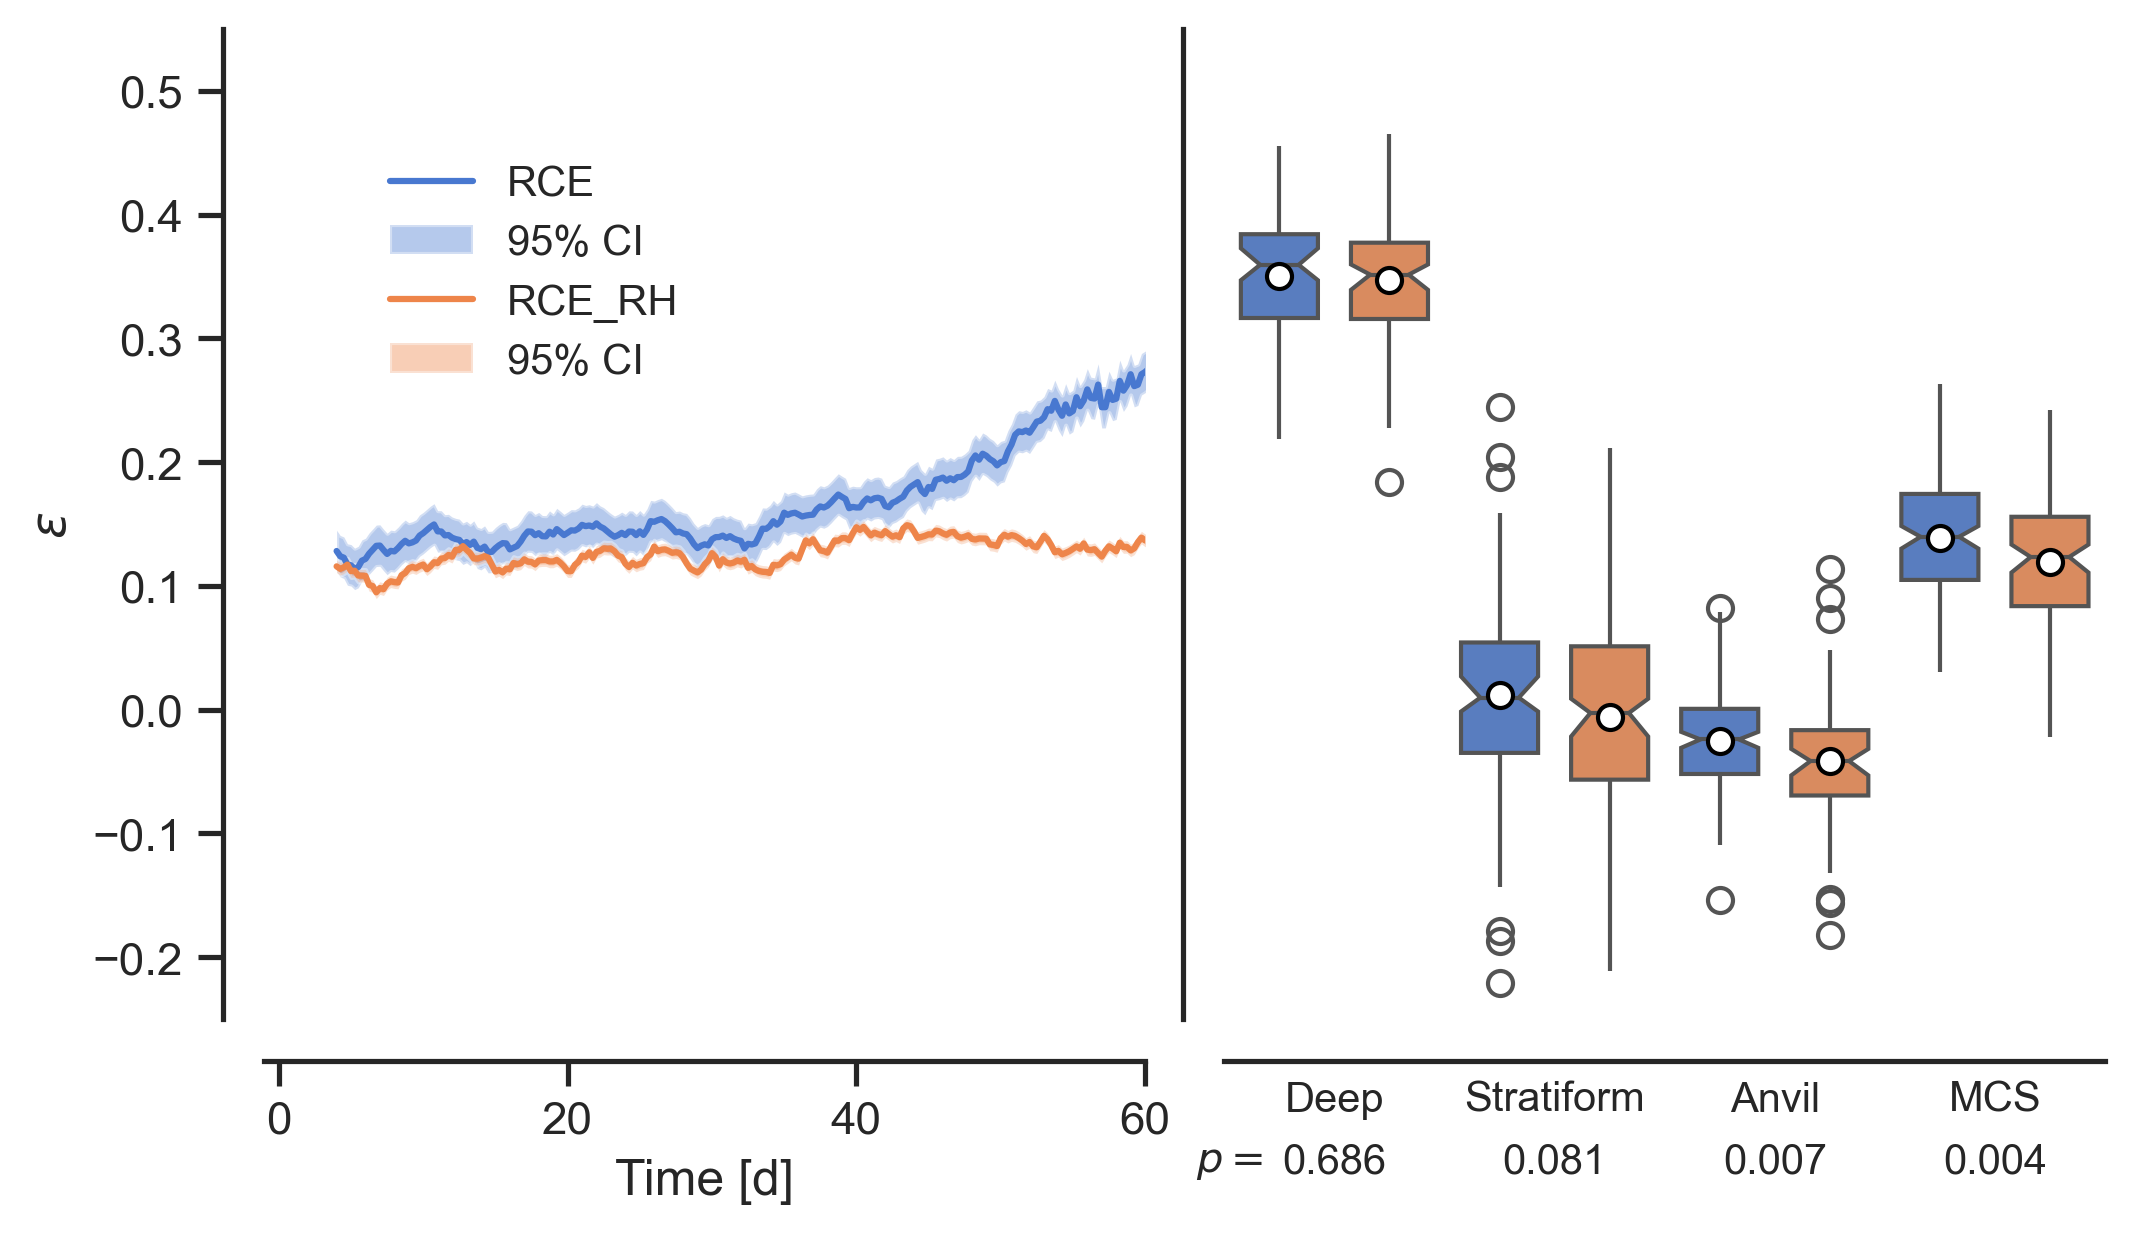

In [89]:
def combined_plot(vars3d, vars3d_rh):

    from scipy.stats import ttest_ind #, mannwhitneyu

    def get_plot_var_pclass(ivars, ipclass):
        nt = ivars['vmf'].shape[0]
        vmfu = np.zeros(nt)
        vmfd = np.zeros(nt)
        for it in range(nt):
            if ipclass < 6:
                ind = (ivars['pclass'][it] == ipclass).nonzero()
            elif ipclass == 6:
                ind = ((ivars['pclass'][it] == 1) | (ivars['pclass'][it] == 4) | (ivars['pclass'][it] == 5)).nonzero()
            vmfu[it] = np.mean(ivars['vmfu'][it][ind])
            vmfd[it] = np.mean(ivars['vmfd'][it][ind])
        var = (1 - (-vmfd/vmfu))
        return var

    fig_x = 7
    fig_y = 4
    # fig, axs = plt.subplots(1,5, width_ratios=[0.6,0.1,0.1,0.1,0.1], figsize=(fig_x,fig_y),
    fig, axs = plt.subplots(1,2, width_ratios=[0.5,0.5], figsize=(fig_x,fig_y),
                            layout='constrained', squeeze=True, dpi=300)

    title = r'$\epsilon$'# = 1 - M_d / M_u$'
    # plt.suptitle(title)
    axs[0].set_ylabel(title)

    sns.set_palette('muted')

    for iax in axs:
        # axs[iax].set_ylim(0,.65)
        iax.set_ylim(-.25,.55)
    y_min, y_max = axs[0].get_ylim()

    #### Time series ########################

    # axs[1].set_ylabel(title)
    axs[0].set_xlabel('Time [d]')
    axs[0].set_xlim(-1, 60)
    sns.despine(offset=10,ax=axs[0], left=False, right=True, bottom=False)
    
    # Read full variable
    ivar = get_plot_var_pclass(vars3d, 6)
    ivar_rh = get_plot_var_pclass(vars3d_rh, 6)

    # Plot line plot with PE for both tests
    for (ivar, legend) in zip([ivar, ivar_rh], test_names[0:2]):
        # axs[0].plot(times_3d, ivar, label=legend, linewidth=1.5, zorder=1)
        ivar_smooth, confidence_interval, nwindow = running_mean_conf(ivar)
        x_smoothed = times_3d[nwindow//2:-nwindow//2+1]
        axs[0].plot(x_smoothed, ivar_smooth, label=legend, linewidth=1.5, zorder=1)
        axs[0].fill_between(x_smoothed, ivar_smooth - confidence_interval,
                            ivar_smooth + confidence_interval, alpha=0.4, label="95% CI", zorder=0)

    # Add legend for axis
    axs[0].legend(fontsize=10, frameon=False, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    #### Boxplots ########################

    pclass_plot = [1,4,5,6]
    # pclass_plot = [1,2,3,4,5,6]
    npclass_plot = len(pclass_plot)

    # Time range
    # d_sel = (0, 20*4)
    d_sel = (0, 29*4)

    colors = sns.color_palette()[:2]

    ivar_all = []
    ivar_rh_all = []
    pvalue_all = []

    for ipclass in range(npclass_plot):

        ivar = get_plot_var_pclass(vars3d, pclass_plot[ipclass])
        ivar_rh = get_plot_var_pclass(vars3d_rh, pclass_plot[ipclass])
        ivar = ivar[d_sel[0]:d_sel[1]]
        ivar_rh = ivar_rh[d_sel[0]:d_sel[1]]

        ivar_all.append(ivar)
        ivar_rh_all.append(ivar_rh)

        # Add labels to boxplot x-axis
        # axs[ipclass+1].text(0.5, y_min-0.05, pclass_names[pclass_plot[ipclass]], ha='center', va='top')#, fontsize=10)

        # Statistical significant (two-sided T-test)
        t_stat, p_value = ttest_ind(ivar,
                                    ivar_rh,
                                    equal_var=True)
        # axs[ipclass+1].text(0.5, y_min-0.10, str(np.round(p_value,3)), ha='center', va='top')#, fontsize=10)
        pvalue_all.append(str(np.round(p_value,3)))

    ivar_all_sequence = []
    for iv, ivar in enumerate(ivar_all):
        ivar_all_sequence.append(ivar)
        ivar_all_sequence.append(ivar_rh_all[iv])

    # sns.boxplot([ivar, ivar_rh],
    sns.boxplot(ivar_all_sequence,
                width=0.7, showmeans=True,
                meanprops={"marker":"o", "markerfacecolor":"white",
                        "markeredgecolor":"black", "markersize":"6"},
                palette=colors,
                ax=axs[1], notch=True, showcaps=False, bootstrap=10000,
                showfliers=True,)
                # boxprops=dict(alpha=0.85))

    # Print p-values below boxplots
    for ipclass in range(npclass_plot):
        x_position = ipclass * 2 + 0.5  # Adjust x-position for each pair of boxplots
        axs[1].text(
            x_position, y_min-0.10,
            pvalue_all[ipclass],
            ha='center', va='top', fontsize=10)
        # Add labels to boxplot x-axis
        axs[1].text(
            x_position, y_min-0.05,
            pclass_names[pclass_plot[ipclass]],
            ha='center', va='top', fontsize=10)

        # Get rid of y-axis ticks
        # axs[ipclass+1].set_yticks([])
        # axs[ipclass+1].set_xticks([])
        # sns.despine(offset=10,ax=axs[ipclass+1], left=True, bottom=False)
    # Get rid of y-axis ticks
    axs[1].set_yticks([])
    axs[1].set_xticks([])
    # sns.despine(offset=10,ax=axs[1], left=True, bottom=False)

    sns.despine(offset=10,ax=axs[1], left=False, bottom=False)
    axs[1].text(-0.15, y_min-0.10, '$p=$', ha='right', va='top', fontsize=10)

    plt.show()
    # Save figure
    # fig.savefig('rce_combined_plotv2.png', bbox_inches='tight')
    plt.close()
    return None

combined_plot(vars3d, vars3d_rh)

#### Stat test

In [16]:
from scipy.stats import ttest_ind #, mannwhitneyu

def stat_test(vars3d, vars3d_rh):

    # Read full variable
    ivar, units, title = get_plot_vars(vars3d)
    ivar_rh, units, title = get_plot_vars(vars3d_rh)
    ivar_all_sav = [ivar, ivar_rh]

    # Statistical significance test

    d_sel = (0, 29*4)
    # d_sel = (30*4, -1)
    time_series_1 = ivar[d_sel[0]:d_sel[1]]
    time_series_2 = ivar_rh[d_sel[0]:d_sel[1]]

    # Perform an independent t-test (or Mann-Whitney U test if data is non-normal)
    t_stat, p_value = ttest_ind(time_series_1, time_series_2, equal_var=True)  # Welch's t-test
    # Alternative: Mann-Whitney U test
    # u_stat, p_value = mannwhitneyu(time_series_1, time_series_2, alternative='two-sided')

    print(f"T-statistic: {t_stat}, P-value: {p_value}")
    print(f"Significant to: {1-p_value}")

    # Annotate the plot with the p-value
    # axs[0].text(0.5, 0.6, f'p = {p_value:.3e}', ha='center', va='center', fontsize=12, transform=axs[0].transAxes)

    # ... (rest of the existing code)
    # plt.show()
    return None

stat_test(vars3d, vars3d_rh)

T-statistic: 0.46818403678845744, P-value: 0.640096349786875
Significant to: 0.359903650213125


### Plot 2D 3-panel plot

In [17]:
def create_3panel(ivars2d, ivars3d, times, itime):

    fig, axs = plt.subplots(1, 3, figsize=(12, 8))

    # Plot cloud class

    title = 'Cloud Class, '+str(times[itime])+' d'

    pclass_plt = ivars3d['pclass'][itime]
    bounds = np.array([-0.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5])
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=6)
    nlevs = len(bounds) - 1
    cmap = plt.get_cmap('Accent_r', nlevs)
    axs[0].pcolormesh(x, y, pclass_plt, cmap=cmap, norm=norm)
    axs[0].set_title(title)
    axs[0].set_xlabel('[km]')
    axs[0].set_ylabel('[km]')
    axs[0].set_aspect('equal')
    cbar = fig.colorbar(axs[0].collections[0], ax=axs[0], fraction=0.03, pad=0.015, ticks=(0,1,2,3,4,5), shrink=0.8)
    cbar.set_ticklabels(['NR', 'DC', 'Cg', 'Sh', 'St', 'An'])

    norm=None

    clevs = np.arange(0.001,0.1,.005)
    clevs2 = np.arange(0.001,0.1,0.005)

    # Plot CWP + IWP overlaid

    title = "CWP (gray) + IWP (red)"
    units = '[mm]'

    pltvar_cwp = ivars2d['lwp'][itime]
    pltvar_iwp = ivars2d['iwp'][itime]
    axs[1].contourf(x, y, pltvar_cwp, cmap='Greys', alpha=0.8, norm=colors.LogNorm(vmin=1e-2))
    axs[1].contourf(x, y, pltvar_iwp, cmap='Reds', alpha=0.55, norm=colors.LogNorm(vmin=1e-2))
    axs[1].set_title(title)
    axs[1].set_xlabel('[km]')
    axs[1].set_aspect('equal')
    fig.colorbar(axs[1].collections[0], ax=axs[1], fraction=0.03, pad=0.03, shrink=0.8, label=units)

    # Plot LW ACRE

    title = "LW ACRE"
    units = '[W/m$^2$]'

    pltvar = ivars2d['lwacre'][itime]
    axs[2].contourf(x, y, pltvar, cmap='RdGy_r', extend='both', norm=colors.TwoSlopeNorm(vcenter=0, vmin=-20, vmax=150))
    axs[2].set_title(title)
    axs[2].set_xlabel('[km]')
    axs[2].set_aspect('equal')
    fig.colorbar(axs[2].collections[0], ax=axs[2], fraction=0.03, pad=0.03, shrink=0.8, label=units)

    plt.tight_layout()
    plt.show()
    plt.close()
    return None

In [18]:
if do_2d_plots:
    itime = 30
    create_3panel(vars2d, vars3d, times_3d, itime)
    create_3panel(vars2d_rh, vars3d_rh, times_3d_rh, itime)

### PClass area

In [19]:
# font = {'family' : 'sans-serif',
#         'weight' : 'normal',
#         'size'   : 12}

# rc('font', **font)

# sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})
sns.set_theme(style="ticks", font_scale=1.2, rc={'xtick.bottom': True, 'ytick.left': True,
                                                 "axes.spines.right": False, "axes.spines.top": False,})

In [20]:
ntest = 2
nt_3d = vars3d['pclass'].shape[0]
npts = nx*nx

In [21]:
# Calculate PClass area

dims = (ntest, npclass, nt_3d)
pclass_area = np.full(dims, np.nan)

for itest, ivars in enumerate([vars3d, vars3d_rh]):
    for it in range(nt_3d):
        for ipclass in range(npclass):
            if ipclass < 6:
                indices = (ivars['pclass'][it,...] == ipclass).nonzero()
            elif ipclass == 6:
                indices = ((ivars['pclass'][it,...] == 1) | (ivars['pclass'][it,...] == 4) | (ivars['pclass'][it,...] == 5)).nonzero()
            pclass_area[itest,ipclass,it] = indices[0].shape[0]/npts

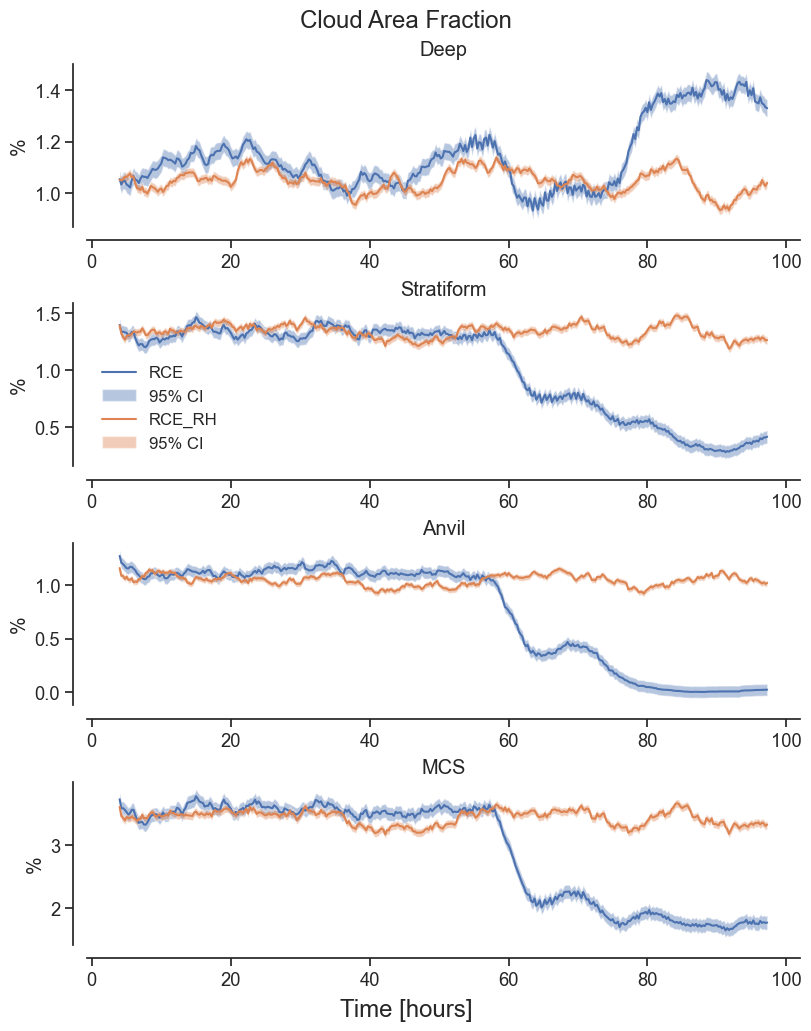

In [34]:
# ctlanom = True
ctlanom = False

pclass_plot = [1,4,5,6]
# pclass_plot = [1,2,3,4,5,6]
nclass_plot = len(pclass_plot)

pltvar_all = np.copy(pclass_area[:,pclass_plot])
pltvar_all *= 1e2 # convert to %

title= 'Cloud Area Fraction'

# create figure
fig_x = 8
# fig_y = 16
fig_y = 2.3*nclass_plot + 1
fig, ax = plt.subplots(nclass_plot,1, figsize=(fig_x,fig_y), layout="constrained",) # row, column
fig.suptitle(title)
fig.supxlabel('Time [hours]')
for iclass in range(nclass_plot):
    pltvar = pltvar_all[:,iclass,:]
    # Difference from CTL
    # Calculate difference FOR EACH ENS MEMBER
    if ctlanom:
        pltvar -= pltvar[:,0,:][:,np.newaxis,:]
    # Plot all sensitivity tests for variable
    for itest in range(ntest):
        tser = pltvar[itest,:]
        # Smooth time series

        pvar_smooth, confidence_interval, nwindow = running_mean_conf(tser)
        x_smoothed = times_3d[nwindow//2:-nwindow//2+1]
        ax[iclass].plot(x_smoothed, pvar_smooth, label=test_names[itest], linewidth=1.5)
        ax[iclass].fill_between(x_smoothed, pvar_smooth - confidence_interval,
                            pvar_smooth + confidence_interval,
                            alpha=0.4, label="95% CI", zorder=0)

        # label = test_names[itest]
        # if ctlanom and itest == 0:
        #     label = '_nolabel_'
        # ax[iclass].plot(mean, label=label)#, linestyle=linestyle[itest], color=linecolor[itest])
        # if conf_shading:
        # if (itest == 0) or (itest == 1):
        # xdim = range(0,nt_3d)
        # ax[iclass].fill_between(xdim, high, low, alpha=0.2)#, color=linecolor[itest])
    ax[iclass].set_title(pclass_names[pclass_plot[iclass]])
    ax[iclass].set_ylabel('%')
    sns.despine(offset=10,ax=ax[iclass])

ax[1].legend(loc="lower left", fontsize=12, frameon=False)
plt.show()

### PClass clusters

In [23]:
from scipy.ndimage import label, sum as ndi_sum

# Arrays to save variables
dims = (ntest, npclass, nt_3d)
number = np.full(dims, np.nan)
mean_size = np.full(dims, np.nan)

# if do_write_pclass_cluster:
for itest, ivars in enumerate([vars3d, vars3d_rh]):

    for it in range(nt_3d):
        for kpclass in range(1,npclass):
            if kpclass < 6:
                labeled_matrix, num_features = label(ivars['pclass'][it,...] == kpclass)
            else:
                labeled_matrix, num_features = label(np.bitwise_or((ivars['pclass'][it,...] == 1), (ivars['pclass'][it,...] >= 4)))
            cluster_sizes = ndi_sum(ivars['pclass'][it,...], labeled_matrix, index=np.arange(1, num_features + 1))
            number[itest, kpclass, it] = num_features
            mean_size[itest, kpclass, it] = np.mean(cluster_sizes) # number of grid cells

/Users/jamesruppert/miniforge3/envs/plotting/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jamesruppert/miniforge3/envs/plotting/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


#### Write out PClass to netcdf

In [24]:
# Get size of data
do_write_netcdf = True
do_write_netcdf = False

if do_write_netcdf:
    size_mb = ivars['pclass'].nbytes / (1024 * 1024)

    # Write out pclass as a netcdf file
    pclass_da = xr.DataArray(
        vars3d['pclass'],
        dims=["time", "y", "x"],  # Replace "time" with the appropriate dimension name
        coords={"time": times_3d, "x": np.arange(nx), "y": np.arange(ny)},  # Replace with actual coordinates if available
        name="pclass"
    )
    pclass_ds = xr.Dataset({"pclass": pclass_da})
    pclass_ds.to_netcdf("pclass_data.nc")

    # Write out pclass as a netcdf file
    pclass_da_rh = xr.DataArray(
        vars3d_rh['pclass'],
        dims=["time", "y", "x"],  # Replace "time" with the appropriate dimension name
        coords={"time": times_3d_rh, "x": np.arange(nx), "y": np.arange(ny)},  # Replace with actual coordinates if available
        name="pclass"
    )
    pclass_ds_rh = xr.Dataset({"pclass": pclass_da_rh})
    pclass_ds_rh.to_netcdf("pclass_data_rh.nc")

#### Histogram

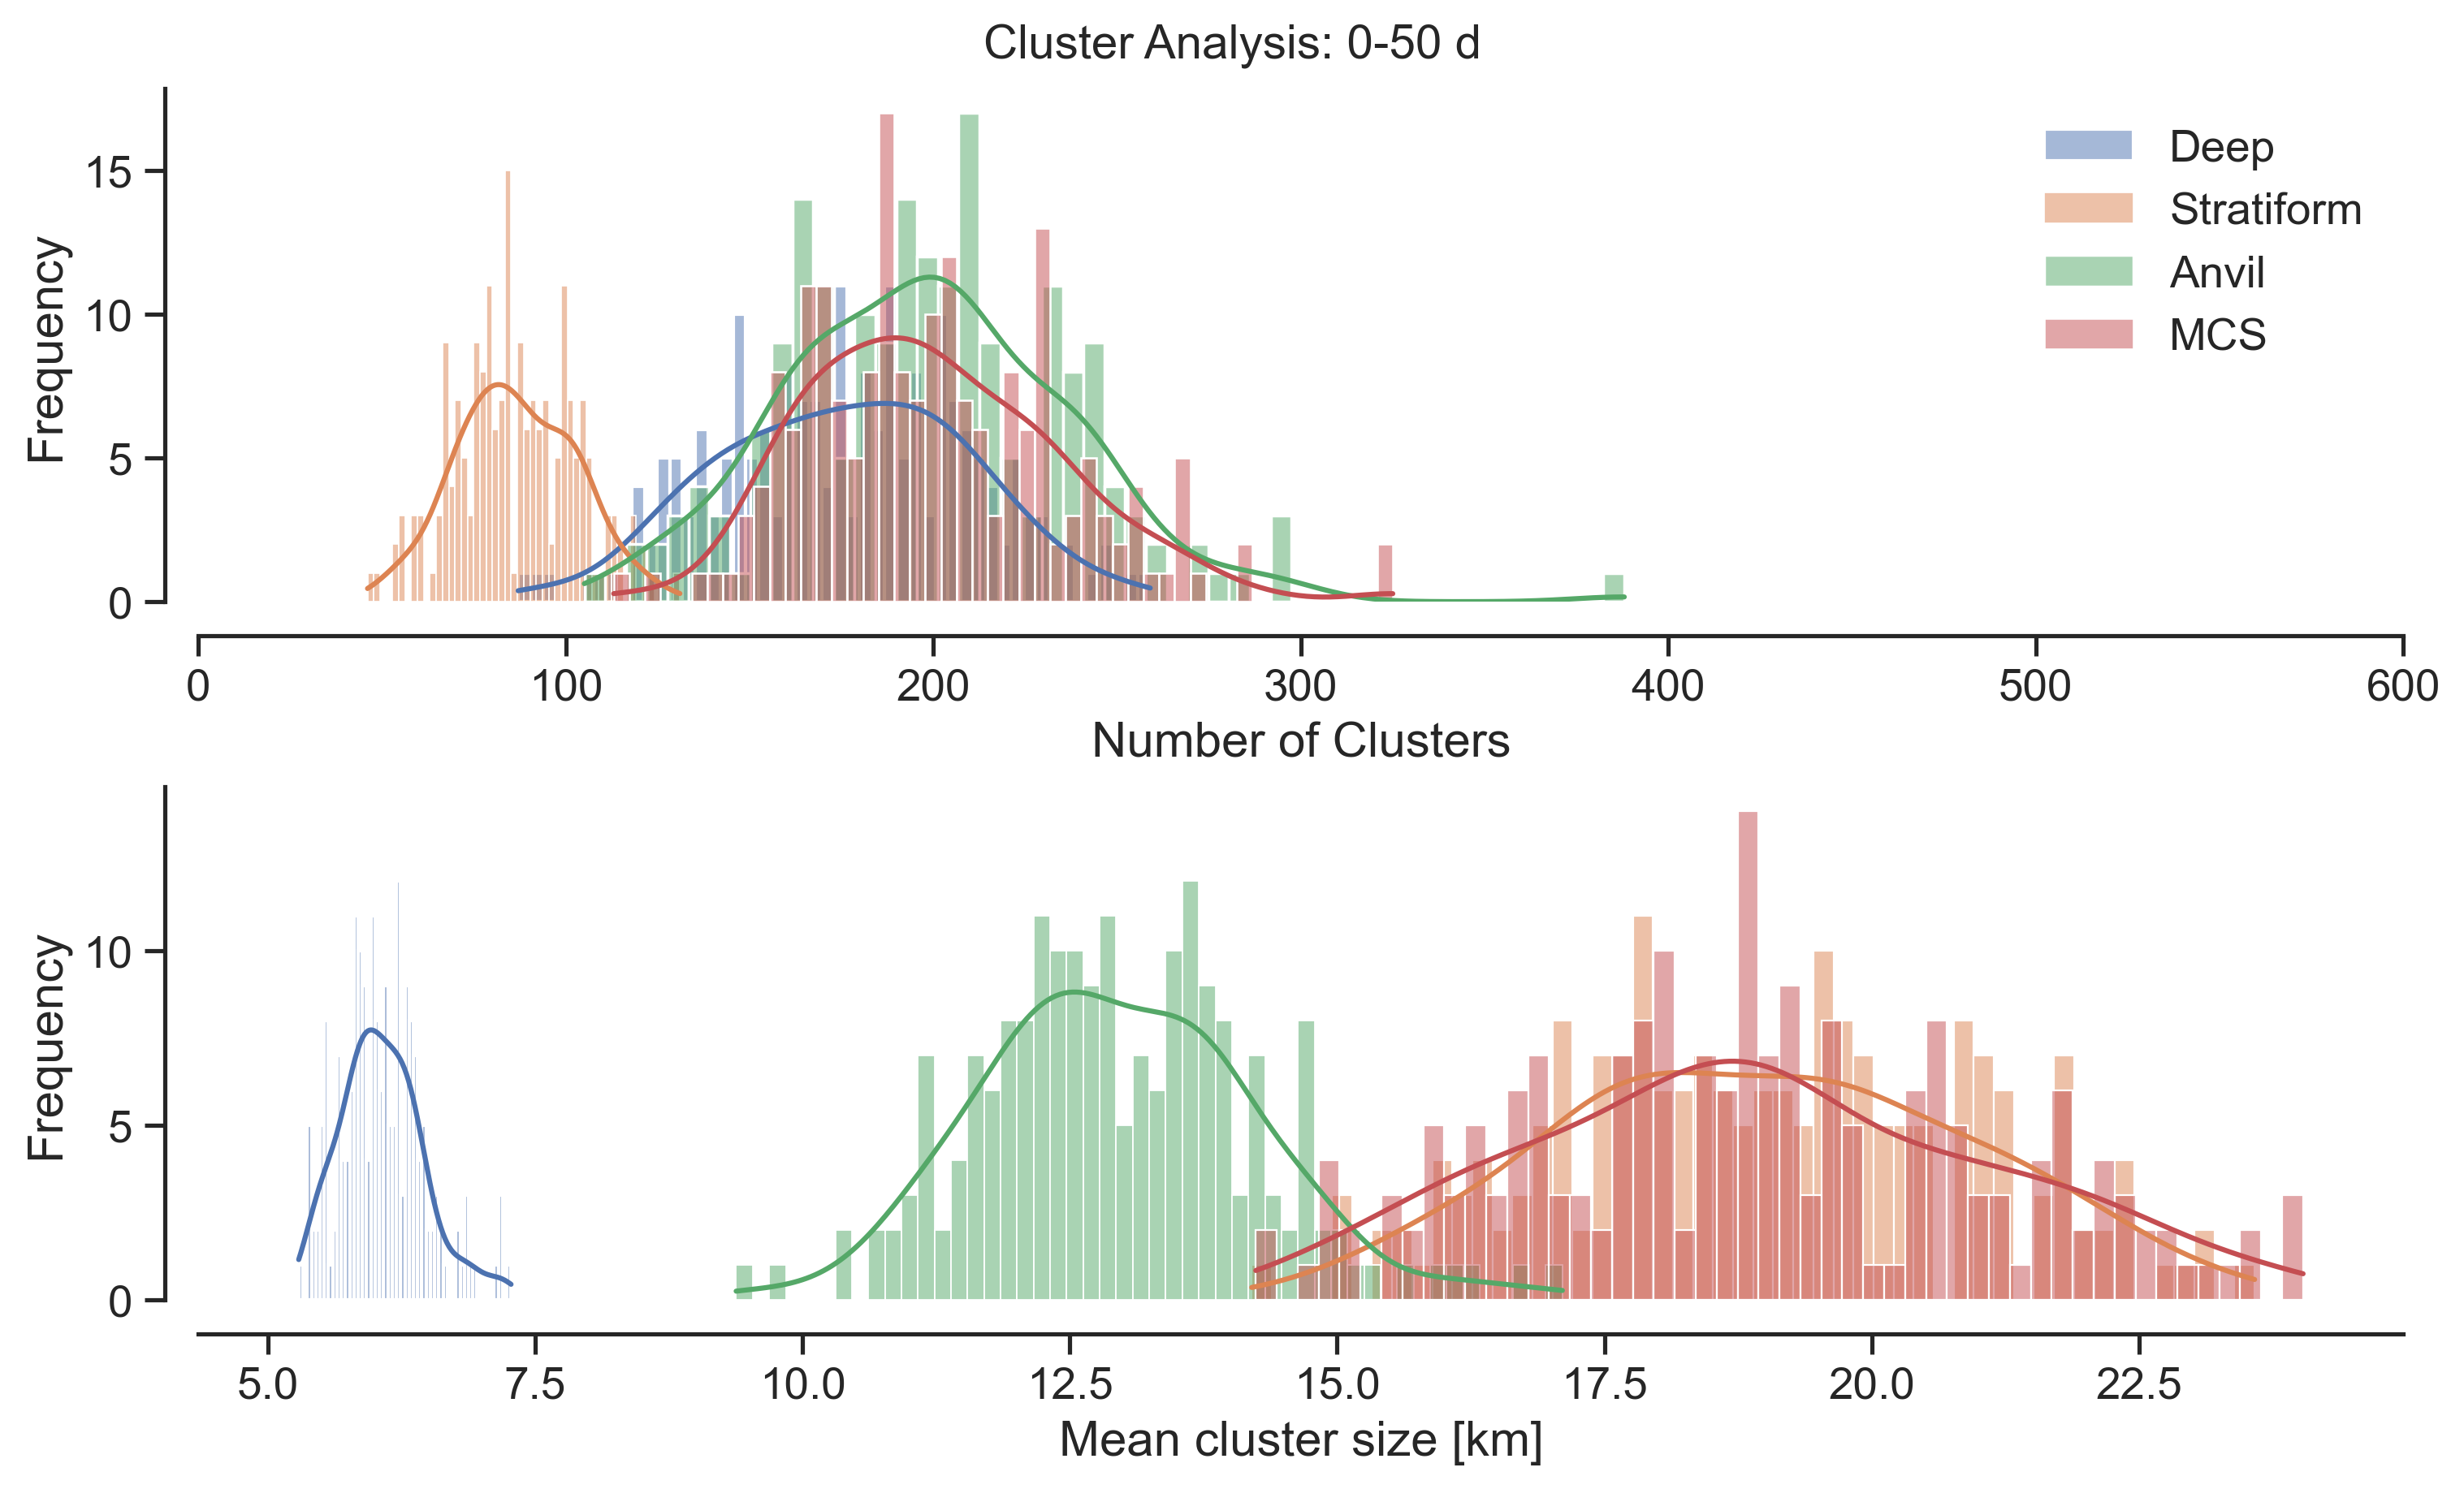

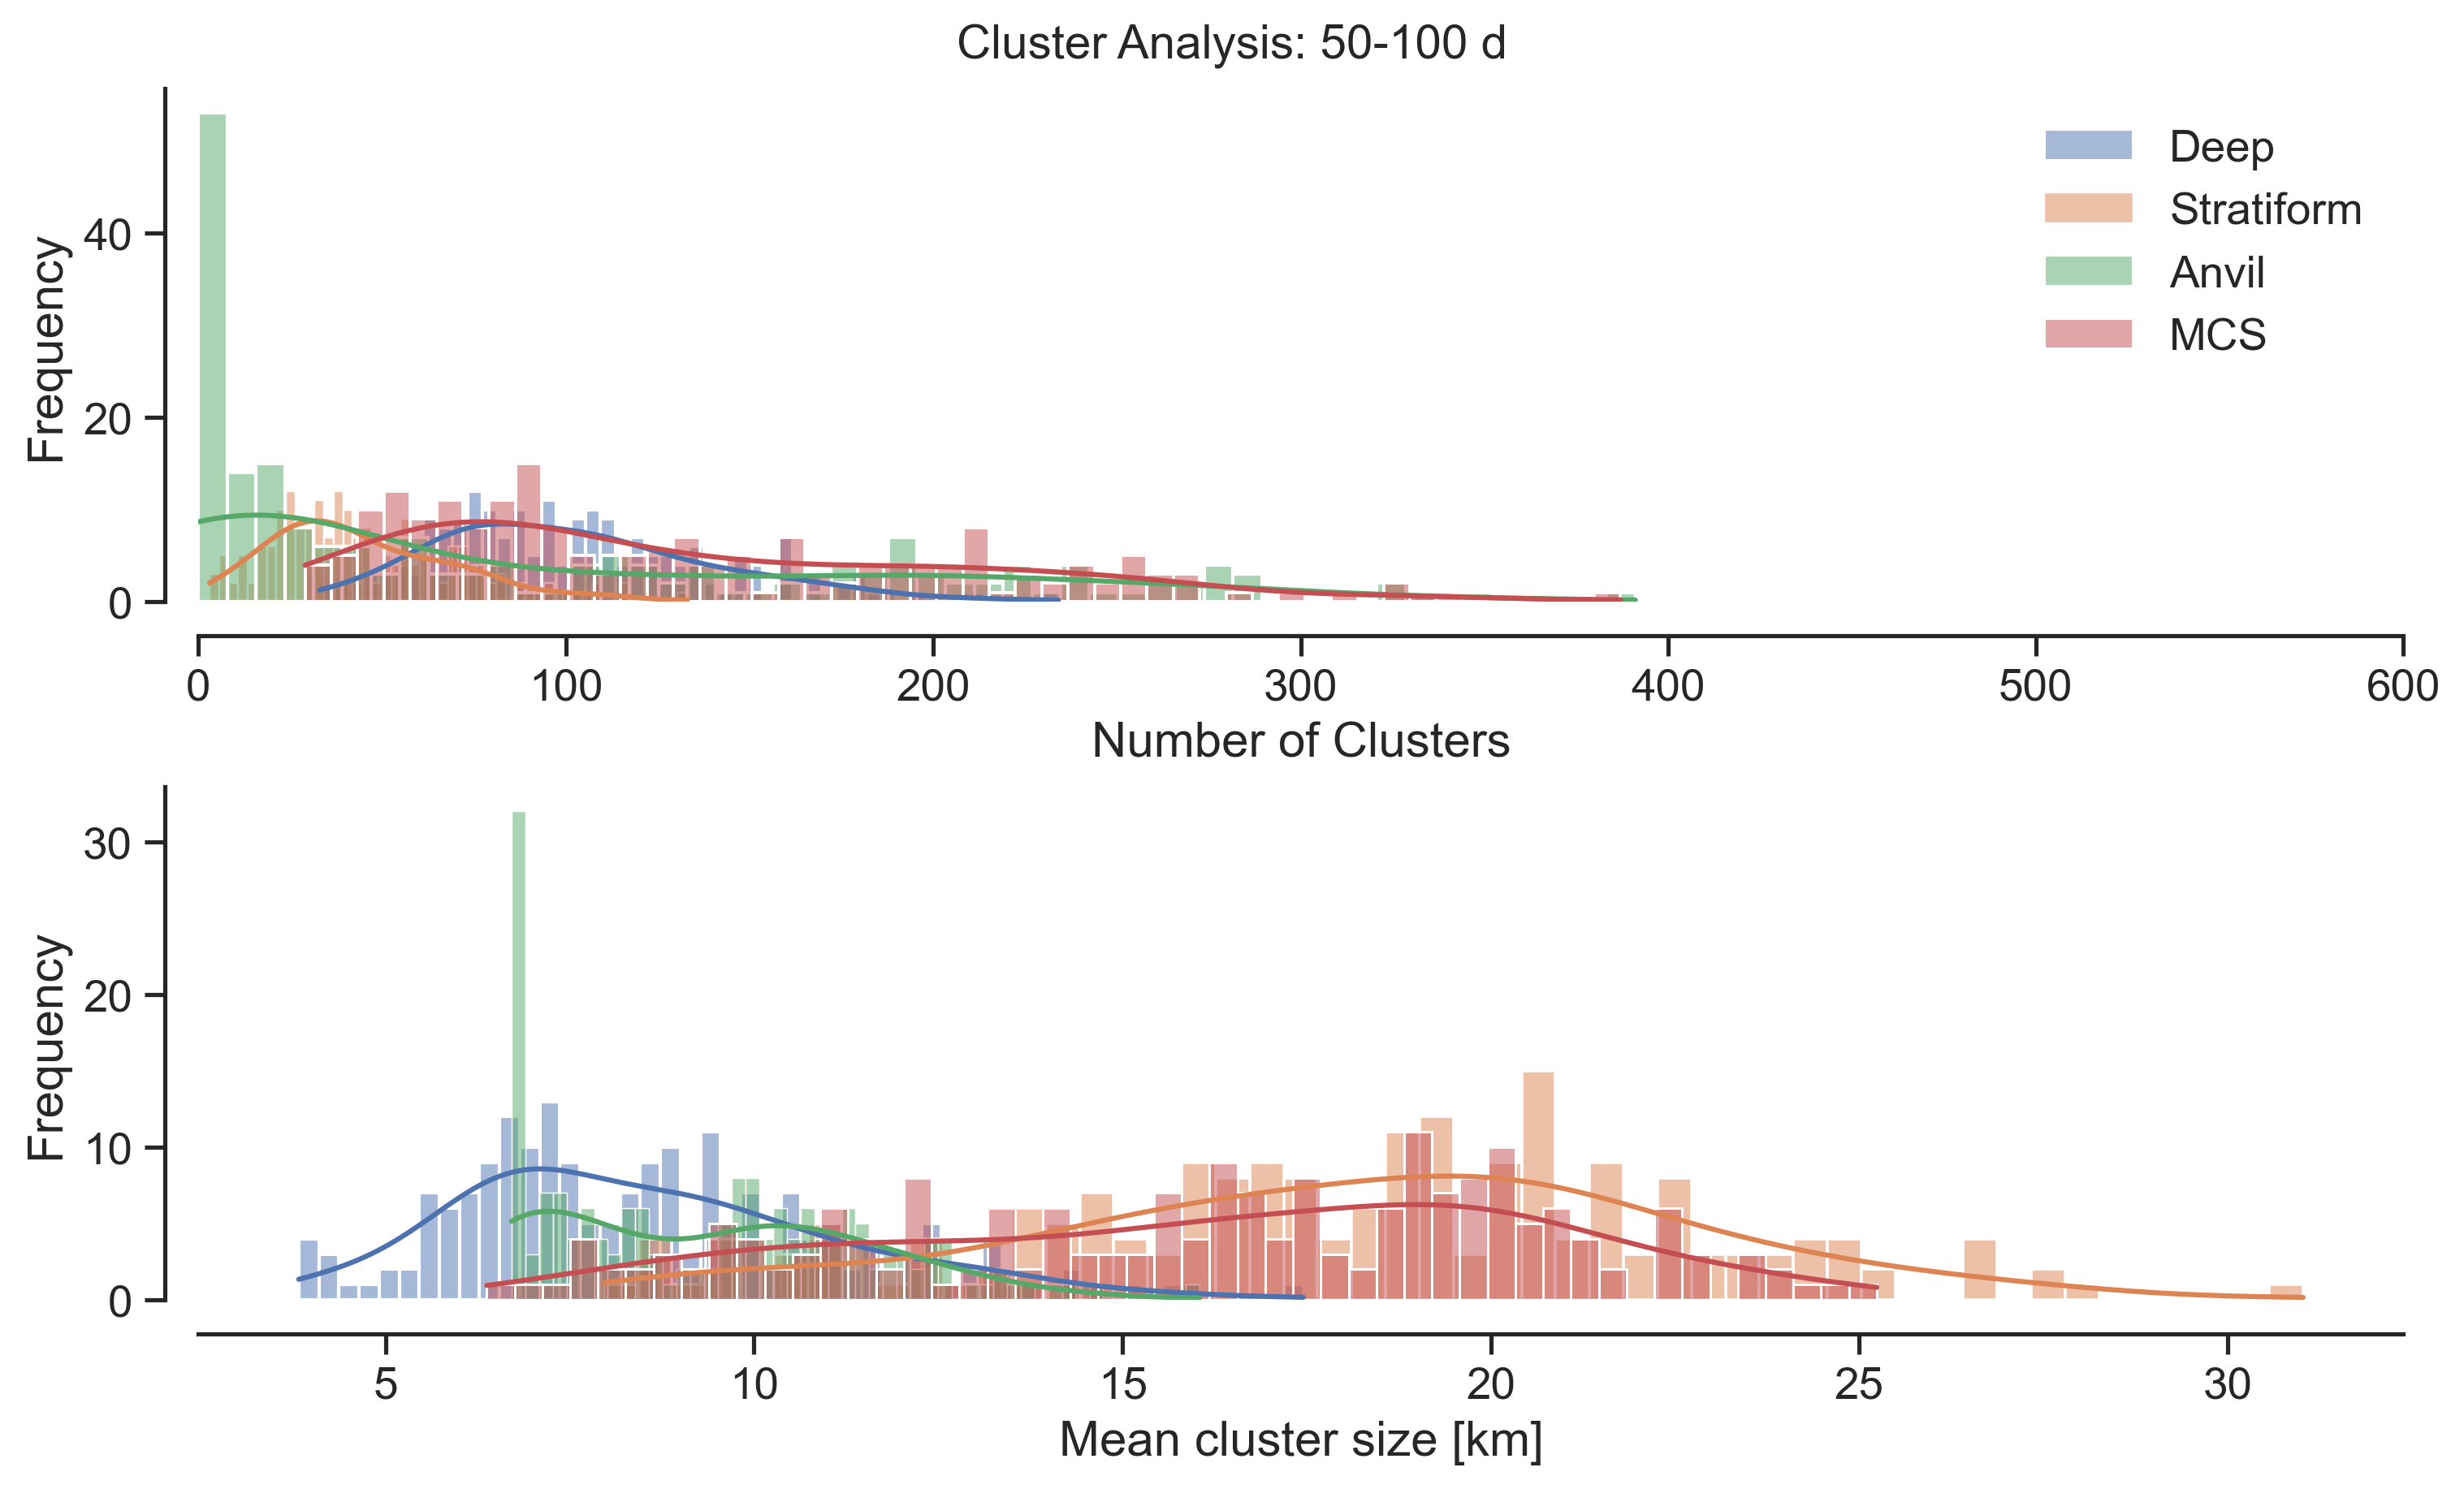

In [25]:
def add_var(figdata, ax):
    ax.set_ylabel('Frequency')
    ax.set_title(figdata['subtitle'])
    ax.set_xlabel(figdata['units'])
    sns.histplot(figdata['pltvar'], ax=ax, kde=True, bins=figdata['bins'], legend=True, label=figdata['pclass_str'])

itest=0
# itest=[0,1,2,3,4]

time0_plot = [0,50]
time_tag = ['0-50 d', '50-100 d']
nt_plot = 196

for it0 in range(len(time0_plot)):

    t0_plot = np.where(times_3d >= time0_plot[it0])[0][0]

    fig_x = 10
    fig_y = 6
    fig, axs = plt.subplots(2, 1, figsize=(fig_x,fig_y), layout='constrained', squeeze=True, dpi=300)
    # fig, axs = plt.subplots(layout='constrained', squeeze=True)

    for kpclass in range(1,npclass):
        if kpclass == 2 or kpclass == 3:
            continue

        figdata = {
            # 'pltvar': number[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
            'pltvar': number[itest,kpclass,t0_plot:t0_plot+nt_plot].flatten(), # dims = (ntest, nmem, npclass, nt)
            'pclass_str': pclass_names[kpclass],
            'subtitle': '',
            'units': 'Number of Clusters',
            'bins': 50,
            }

        add_var(figdata, axs[0])

        # diam=np.sqrt(3**2 + 3**2)
        # Assume circular geometry
        # area = mean_size
        # area = pi*r^2
        # r = np.sqrt(area/pi)
        # radius = np.sqrt((mean_size*delta_x2)/np.pi)
        # Use area of a square grid cell instead = 3km x 3km = 9 km^2
        delta_x2 = 3*3 # km^2, area of each grid cell
        sizes = np.sqrt(mean_size*delta_x2)

        figdata = {
            # 'pltvar': mean_size[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
            # 'pltvar': mean_size[itest,:,kpclass,:].flatten()*diam, # dims = (ntest, nmem, npclass, nt)
            'pltvar': sizes[itest,kpclass,t0_plot:t0_plot+nt_plot].flatten(), # dims = (ntest, nmem, npclass, nt)
            'pclass_str': pclass_names[kpclass],
            'units': 'Mean cluster size [km]',
            'subtitle': '',
            'bins': 50,
            }

        add_var(figdata, axs[1])
        # add_var(figdata, axs[0,1])

    axs[0].set_xlim(0, 600)

    sns.despine(ax=axs[0], offset=10)
    sns.despine(ax=axs[1], offset=10)
    # axs[0].set_title('Number')
    # axs[1].set_title('Mean Size')
    plt.suptitle('Cluster Analysis: '+time_tag[it0], fontsize=14)

    axs[0].legend(frameon=False, loc='upper right')
    plt.show()
    plt.close()

#### Time series

In [32]:
def do_tser(figdata, do_legend=False):
    ntest = figdata['number'].shape[0]
    smooth=True
    # smooth=False
    pclass_plot = [1,4,5,6]
    # pclass_plot = [1,2,3,4,5,6]
    npclass_plot = len(pclass_plot)
    fig_x, fig_y = 10, 12
    fig, ax = plt.subplots(npclass_plot,2, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
    ax[npclass_plot-1,0].set_xlabel('Time [hour]')
    ax[npclass_plot-1,1].set_xlabel('Time [hour]')
    # t_max = t1_test
    # linecolor=['black', 'red', 'blue', 'green', 'green']
    # linecolor=['black', 'blue', 'red', 'green', 'green']
    # linecolor=['blue', 'red', 'green', 'green']
    # linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
    # linestyle[-1]='dashed'
    for ipclass in range(npclass_plot):
        for icol in range(2):
            if icol == 0:
                pltvar = figdata['number']
                ax[0,icol].set_title('Number')
                ax[ipclass,icol].set_ylabel(figdata['units'][pclass_plot[ipclass]])
            else:
                pltvar = figdata['size']
                # ax[0,icol].set_title('Mean Diamater [km]')
                ax[0,icol].set_title('Mean size [km]')
            # Plot zero line
            # ax[ipclass,icol].axhline(0, color='black', linewidth=1)
            pltvar = pltvar[:,pclass_plot[ipclass],:]
            # ax[ipclass,icol].set_xlim([0,t_max])
            for itest in range(ntest):
                pvar = pltvar[itest]
                pvar_smooth, confidence_interval, nwindow = running_mean_conf(pvar)
                x_smoothed = times_3d[nwindow//2:-nwindow//2+1]
                ax[ipclass,icol].plot(x_smoothed, pvar_smooth, label=figdata['tests_str'][itest], linewidth=1.5)
                ax[ipclass,icol].fill_between(x_smoothed, pvar_smooth - confidence_interval,
                                    pvar_smooth + confidence_interval,
                                    alpha=0.4, label="95% CI", zorder=0)
                # mean, low, high = mean_confidence_interval(pvar)
                # ax[ipclass,icol].plot(pvar, linestyle=linestyle[itest], color=linecolor[itest], label=figdata['tests_str'][itest])
                # var_smooth = pd.DataFrame(mean)
                # var_smooth = var_smooth.rolling(window=3, center=True, closed='both').mean()
                # ax[iprof].plot(var_smooth, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
                # if (itest == 0) or (itest == 2):
                # if (itest == 1) or (itest == 2):
                # xdim = range(0,mean.shape)
                # ax[ipclass,icol].fill_between(xdim, high, low, alpha=0.1, color=linecolor[itest])
            if do_legend & (ipclass == 0) & (icol == 1):
                ax[ipclass,icol].legend(loc='upper left', frameon=False, 
                                        bbox_to_anchor=(0.1, 0.85))
            sns.despine(offset=10, ax=ax[ipclass,icol])
    plt.show()
    plt.close()

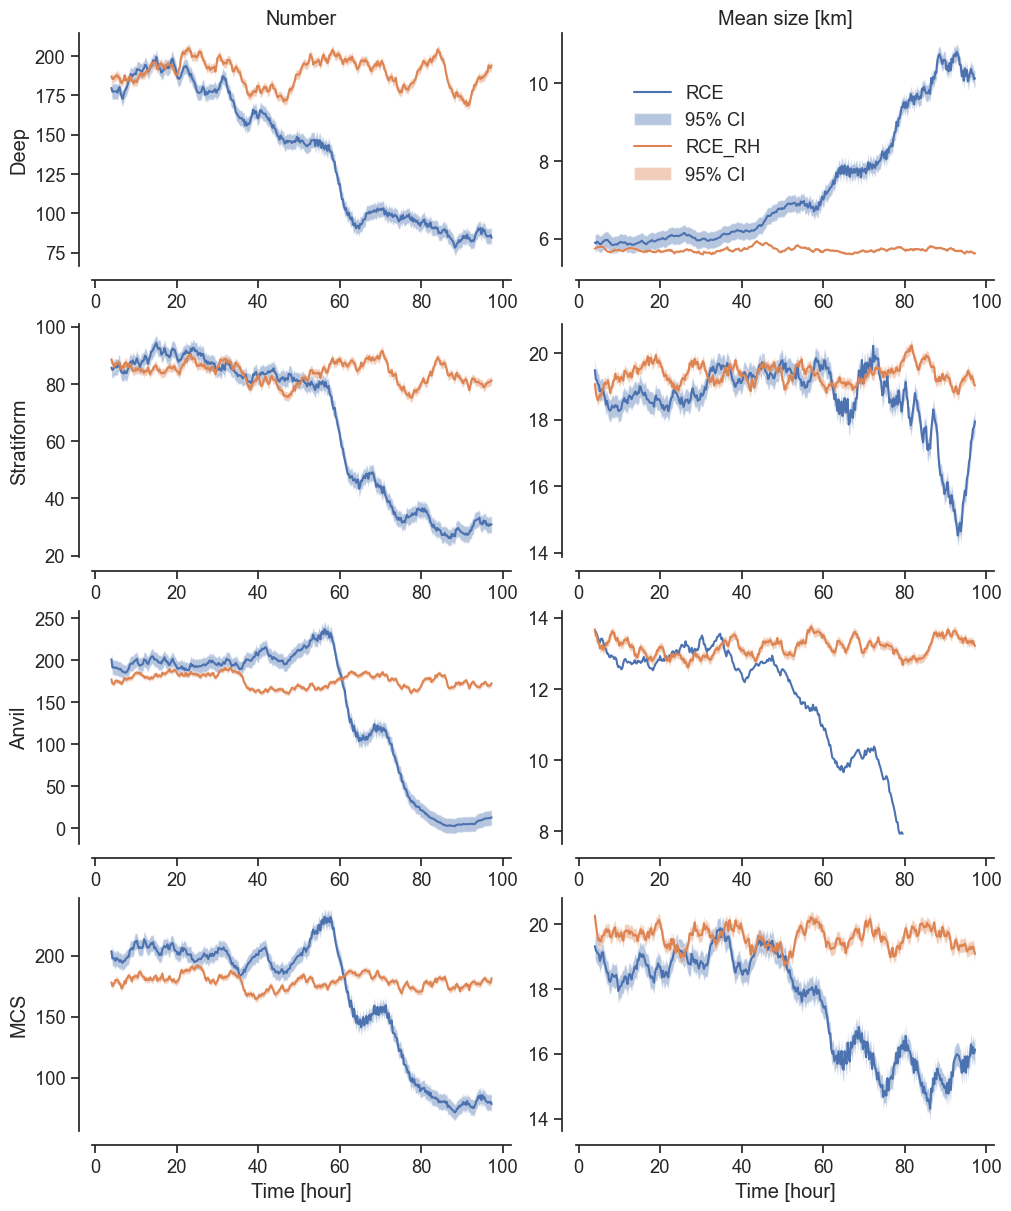

In [33]:
# area_grid_cell = 9 # km**2
# diam = 2*np.sqrt((mean_size*area_grid_cell)/np.pi)
sizes_sqrt = np.sqrt(mean_size*delta_x2)

def ctldiff(invar):
    # return invar - invar[0,...]
    return invar
    # ctl_ensmean = np.mean(invar[0,...], axis=0)
    # return invar - ctl_ensmean[np.newaxis,np.newaxis,...]

# Difference from CTL
number_ctlanom = ctldiff(number)
# radius_ctlanom = ctldiff(radius)
# mean_size_ctlanom = ctldiff(mean_size)
mean_size_ctlanom = ctldiff(sizes_sqrt)

figdata = {
    # 'size': diam, # dims = (ntest, nmem, npclass, nt)
    # 'size': mean_size, # dims = (ntest, nmem, npclass, nt)
    # 'number': number, # dims = (ntest, nmem, npclass, nt)
    'size': mean_size_ctlanom, # dims = (ntest, nmem, npclass, nt)
    'number': number_ctlanom, # dims = (ntest, nmem, npclass, nt)
    'tests_str': test_names,
    'units': pclass_names,
    }

do_legend=True
# if kpclass == npclass-1:
#     do_legend=True

do_tser(figdata, do_legend=do_legend)